In [184]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cv2
from collections.abc import Callable

Константы

In [185]:
a = 8
b = 4
t0 = np.pi
t1 = 2 * np.pi
t2 = 5 * np.pi

STEPS_PER_T = 10000

Util функции

In [186]:
def create_plot(x, y_arrays, x_label, y_label, func_labels=None, colors=None, xPi=False,
                base=np.pi, marker=[None], linestyle=["-"], markersize=[10], linewidth=[1], markevery=None):
  fig, ax = plt.subplots()

  if markevery is None:
    markevery = [1] * len(y_arrays)

  if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * (len(y_arrays) // 7 + 1)

  if type(x[0]) == list:
    for i, y in enumerate(y_arrays):
      if func_labels is not None:
        ax.plot(x[i], y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
                linewidth=linewidth[i], label=func_labels[i], markevery=markevery[i])
        ax.legend()
      else:
        ax.plot(x[i], y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
                linewidth=linewidth[i], markevery=markevery[i])
  else:
    for i, y in enumerate(y_arrays):
      if func_labels is not None:
        ax.plot(x, y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
                linewidth=linewidth[i], label=func_labels[i], markevery=markevery[i])
        ax.legend()
      else:
        ax.plot(x, y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
              linewidth=linewidth[i], markevery=markevery[i])

  ax.grid(True)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  if xPi:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
      lambda val, pos: f'{int(val/np.pi)}π' if val % np.pi == 0 and val != 0 else
                    (f'{val/np.pi:.1f}π' if val != 0 else '0')
    ))

  return ax

def draw_subplots(axes_list, nrows=1, ncols=None, height=4, width=7):
  num_plots = len(axes_list)
  if ncols is None:
      ncols = (num_plots + nrows - 1) // nrows

  fig, axes = plt.subplots(nrows, ncols, figsize=(width * ncols, height * nrows))
  axes = np.array(axes).reshape(-1)

  for i, ax in enumerate(axes_list):
    for line in ax.get_lines():
      axes[i].plot(line.get_xdata(), line.get_ydata(), color=line.get_color(),
                   linestyle=line.get_linestyle(), marker=line.get_marker(),
                   markersize=line.get_markersize(), linewidth=line.get_linewidth(),
                   label=line.get_label())
    if ax.get_legend() is not None:
      axes[i].legend()
    axes[i].set_xlabel(ax.get_xlabel())
    axes[i].set_ylabel(ax.get_ylabel())
    axes[i].grid(True)

    if ax.xaxis.get_major_formatter() is not None:
      axes[i].xaxis.set_major_locator(ax.xaxis.get_major_locator())
      axes[i].xaxis.set_major_formatter(ax.xaxis.get_major_formatter())

  for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

# Квадратная волна

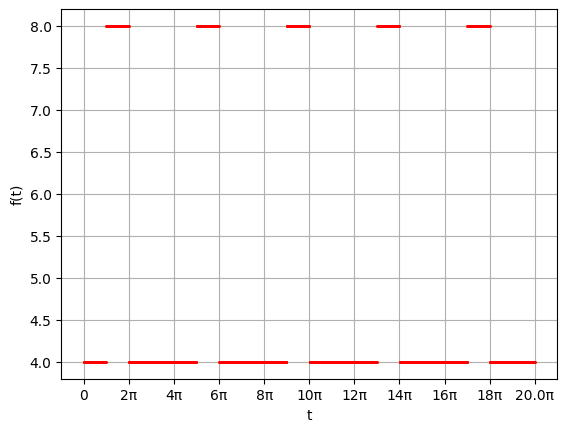

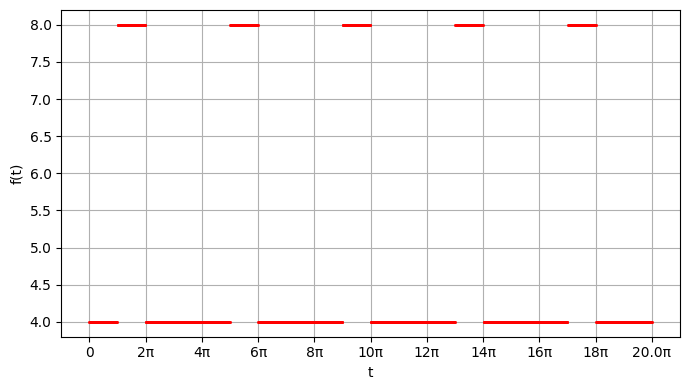

In [187]:
T1 = t2 - t0

def rect_func(x: float) -> float:
  t0f = 0
  t1f = t1 - t0
  t2f = t2 - t0
  T1f = t2f - t0f
  if t0f <= np.mod(x - t0, T1f) < t1f:
    return a
  elif t1f <= np.mod(x - t0, T1f) < t2f:
    return b

x1 = np.linspace(0, 20 * np.pi, 1000)
y1 = [rect_func(t) for t in x1]
rect_f_graph = create_plot(x1, [y1], "t", "f(t)", None, ["red"], True, 2 * np.pi, marker=["s"], linestyle=["None"], markersize=[1])
draw_subplots([rect_f_graph])


#### Функции для вычисления коэффициентов

In [188]:
def Integrate(f: Callable[[float], float], x_min: float, x_max: float, steps: int) -> float:
  result = 0
  delta_x = (x_max - x_min) / steps
  x_current = x_min
  for i in range(steps):
    result += f(x_current) * delta_x
    x_current += delta_x
  return result

def get_an_bn(f: Callable[[float], float], t0: float, T: float, n: int) -> tuple:
  an = 2 / T * Integrate(lambda x: f(x) * np.cos(2 * np.pi * n / T * x), t0, t0 + T, int(T) * STEPS_PER_T)
  bn = 2 / T * Integrate(lambda x: f(x) * np.sin(2 * np.pi * n / T * x), t0, t0 + T, int(T) * STEPS_PER_T)
  return (an, bn)

def get_cn_cn(f: Callable[[float], float], t0: float, T: float, n: int) -> tuple:
  cn = 1 / T * Integrate(lambda x: f(x) * np.exp(-1j * 2 * np.pi * n / T * x), t0, t0 + T, int(T) * STEPS_PER_T)
  c_n = 1 / T * Integrate(lambda x: f(x) * np.exp(-1j * 2 * np.pi * (-n) / T * x), t0, t0 + T, int(T) * STEPS_PER_T)
  return (cn, c_n)

In [189]:
def print_coefs(f: Callable[[float], float], t0: float, T: float, N: int, precision: int, rp_ab: int, rp_c: int) -> None:
  a0 = get_an_bn(f, t0, T, 0)[0]
  c0 = get_cn_cn(f, t0, T, 0)[0]
  print("Коэффициенты рядов Фурье:")
  print(f"a_0: {np.round(a0, precision):>{precision + rp_ab}}\t\t\t"
        f"c_0: {np.round(c0, precision):>{precision + rp_c}}")
  for n in range(1, N + 1):
    an, bn = get_an_bn(f, t0, T, n)
    cn, c_n = get_cn_cn(f, t0, T, n)
    print(f"a_{n}: {np.round(an, precision):>{precision + rp_ab}}, b_{n}: {np.round(bn, precision):>{precision + rp_ab}}\t"
          f"c_{n}: {np.round(cn, precision):>{precision + rp_c}}, c_-{n}: {np.round(c_n, precision):>{precision + rp_c}}")

##### Вычисление коэффициентов для квадратной волны

In [190]:
print_coefs(rect_func, t0, T1, 2, 3, 3, 12)

Коэффициенты рядов Фурье:
a_0:   10.0			c_0:          (5+0j)
a_1: -1.273, b_1:  1.273	c_1: (-0.637-0.637j), c_-1: (-0.637+0.637j)
a_2:   -0.0, b_2: -1.273	c_2:     (-0+0.637j), c_-2:     (-0-0.637j)


## Графики для различных N

In [191]:
def FN(x_array: list, f: Callable[[float], float], N: int, t0: float, T: float,) -> list:
  result = [get_an_bn(f, t0, T, 0)[0] / 2] * len(x_array)
  omega_n_coef = 2 * np.pi / T
  for n in range(1, N + 1):
    an, bn = get_an_bn(f, t0, T, n)
    for i in range(len(x_array)):
      result[i] += an * np.cos(omega_n_coef * n * x_array[i]) + bn * np.sin(omega_n_coef * n * x_array[i])
  return result

def GN(x_array: list, f: Callable[[float], float], N: int, t0: float, T: float,) -> list:
  result = [get_cn_cn(f, t0, T, 0)[0]] * len(x_array)
  omega_n_coef = 2 * np.pi / T
  for n in range(1, N + 1):
    cn, c_n = get_cn_cn(f, t0, T, n)
    for i in range(len(x_array)):
      result[i] += cn * np.exp(1j * omega_n_coef * n * x_array[i]) + c_n * np.exp(1j * omega_n_coef * (-n) * x_array[i])
  return result

/home/ns/Desktop/FM/Lab1/labvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ns/Desktop/FM/Lab1/labvenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


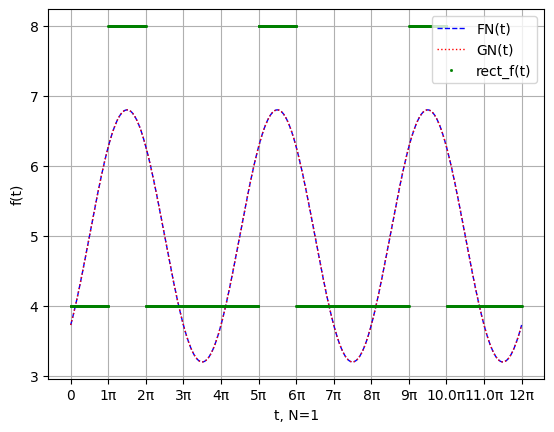

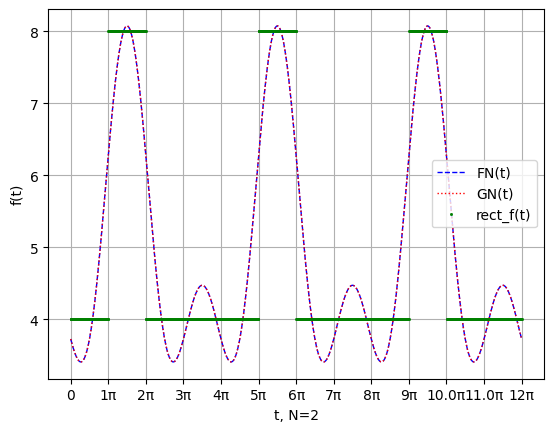

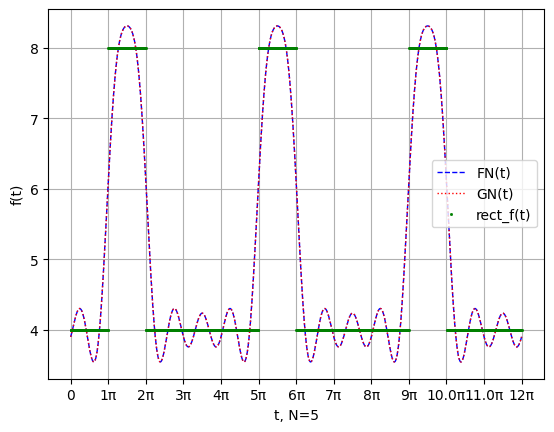

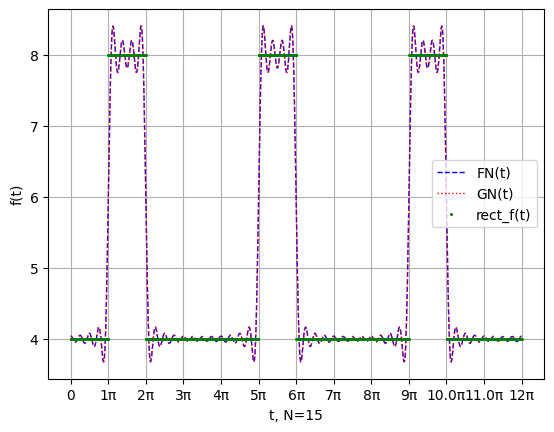

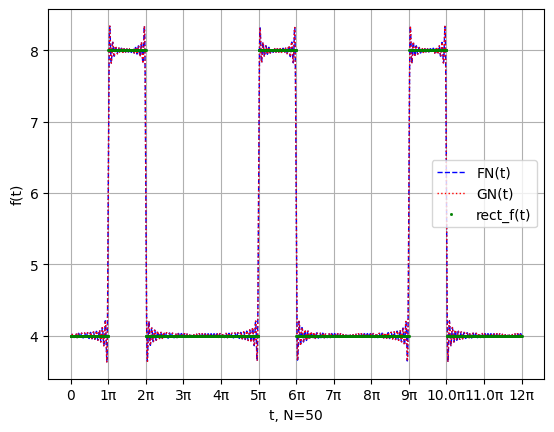

In [192]:
N = [1,2,5,15,50]
x1_1 = np.linspace(0, 12 * np.pi, 1200)

graphs = []
y1_1 = [rect_func(t) for t in x1_1]

for n in N:
  yF = FN(x1_1, rect_func, n, t0, T1)
  yG = GN(x1_1, rect_func, n, t0, T1)

  graphs.append(create_plot(x1_1, [yF, yG, y1_1], f"t, N={n}", "f(t)", ["FN(t)", "GN(t)", "rect_f(t)"],
                colors=["blue", "red", "green"], linestyle=["--", ":", "None"], marker=["None", "None", "s"],
                linewidth=[1, 1, 1], markersize=[1, 1, 1], xPi=True))

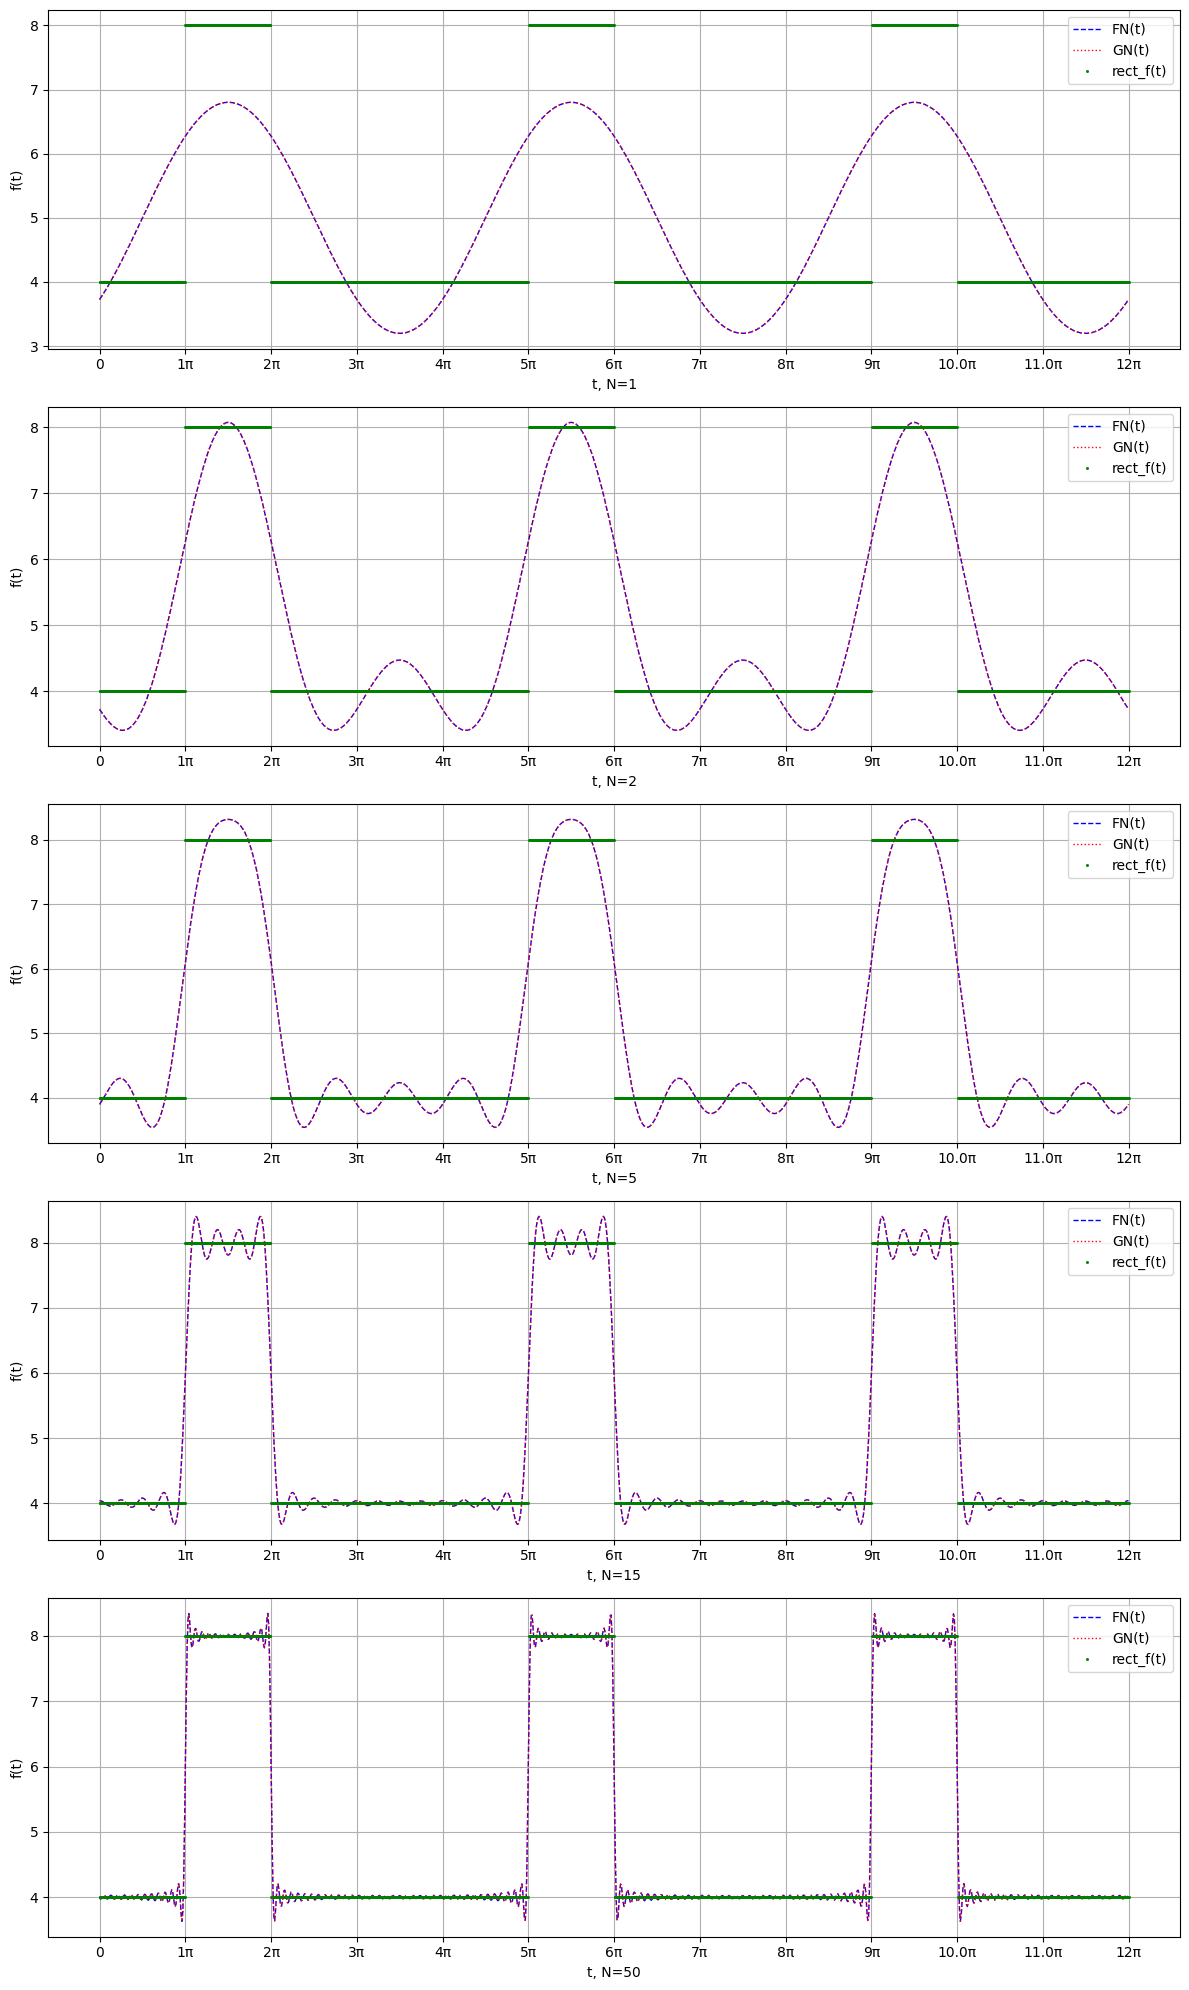

In [193]:
draw_subplots(graphs, nrows=5, ncols=1, height=4, width=12)

### Проверка равенства Парсеваля
##### Для G_N(t)

In [194]:
def get_quad_cn_hatch(f: Callable[[float], float], t0: float, T: float, n: int) -> float:
  cn = np.absolute(
    Integrate(lambda x: f(x) * np.exp(-1j * 2 * np.pi * n / T * x) / T ** 0.5, t0, t0 + T, int(T) * STEPS_PER_T)
    ) ** 2
  return cn

def sum_cn_coefs(f: Callable[[Callable[[float], float], float, float, int], float],
              f_in: Callable[[float], float], f_in_t0: float, f_in_T: float, 
              i_min: int, i_max: int) -> float:
  result = 0
  for i in range(i_min, i_max + 1):
    result += f(f_in, f_in_t0, f_in_T, i)
  return result

def func_quad_norm(f:Callable[[float], float], x_min: float, x_max: float) -> float:\
  return Integrate(lambda x: abs(f(x)) ** 2, x_min, x_max, STEPS_PER_T)

In [195]:
cn_sum1 = sum_cn_coefs(get_quad_cn_hatch, rect_func, t0, T1, -50, 50)
rect_func_norm = func_quad_norm(rect_func, t0, t2)

In [196]:
print("Сумма коэффицентов c_n': ", cn_sum1)
print("Квадрат нормы функции: ", rect_func_norm)
print("Отклонение: ", round(abs(rect_func_norm - cn_sum1) / rect_func_norm * 100, 2), "%")

Сумма коэффицентов c_n':  351.4588996440023
Квадрат нормы функции:  351.85837720194905
Отклонение:  0.11 %


##### Для F_N(t)

In [197]:
def sum_an_bn_coefs(f: Callable[[Callable[[float], float], float, float, int], float],
              f_in: Callable[[float], float], f_in_t0: float, f_in_T: float, 
              i_min: int, i_max: int) -> float:
  result = get_an_bn(f_in, f_in_t0, f_in_T, 0)[0] ** 2 / 2
  for i in range(i_min, i_max + 1):
    result += f(f_in, f_in_t0, f_in_T, i)[0] ** 2 + f(f_in, f_in_t0, f_in_T, i)[1] ** 2
  return result * f_in_T / 2

In [198]:
an_bn_sum1 = sum_an_bn_coefs(get_an_bn, rect_func, t0, T1, 1, 50)

In [199]:
print("Сумма коэффицентов a_n', b_n': ", an_bn_sum1)
print("Отклонение: ", round(abs(rect_func_norm - an_bn_sum1) / rect_func_norm * 100, 2), "%")

Сумма коэффицентов a_n', b_n':  351.4588996435726
Отклонение:  0.11 %


# Чётная функция

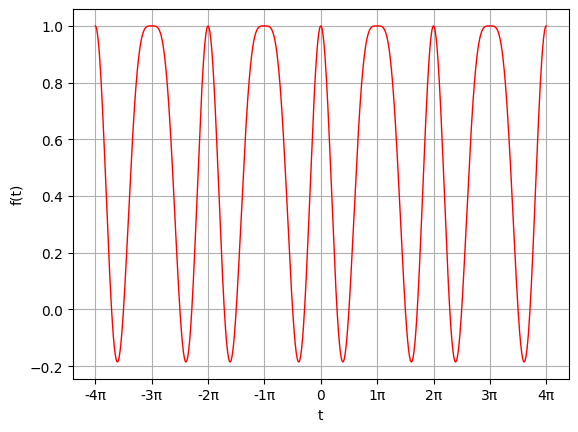

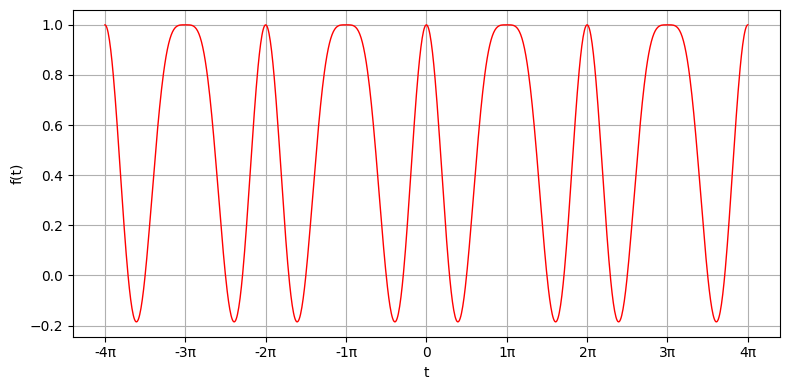

In [200]:
def even_func(x: float) -> float:
    return np.cos(x) ** 2 - np.sin(x) ** 2 * np.cos(x)

x2 = np.linspace(-4 * np.pi, 4 * np.pi, 1000)
y2 = [even_func(t) for t in x2]
even_f_graph = create_plot(x2, [y2], "t", "f(t)", None, ["red"], True, np.pi, linestyle=["-"], markersize=[1])
draw_subplots([even_f_graph], height=4, width=8)

## Вычисление коэффициентов чётной функци

In [201]:
print_coefs(even_func, 0, 2 * np.pi, 2, 3, 3, 12)

Коэффициенты рядов Фурье:
a_0:    1.0			c_0:        (0.5+0j)
a_1:  -0.25, b_1:    0.0	c_1:     (-0.125-0j), c_-1:     (-0.125+0j)
a_2:    0.5, b_2:    0.0	c_2:       (0.25-0j), c_-2:       (0.25+0j)


## Графики для различных N

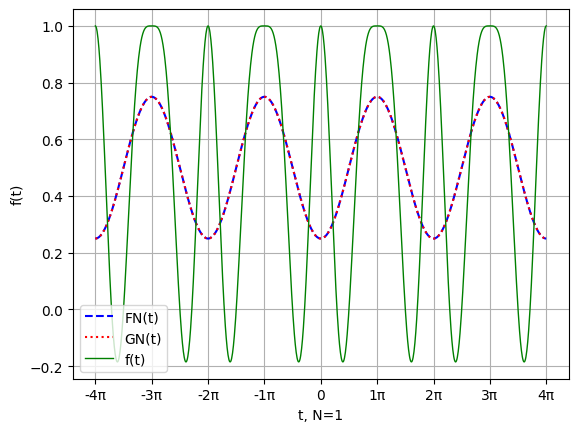

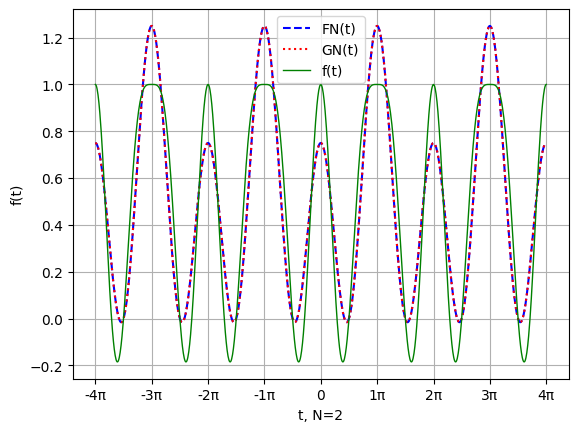

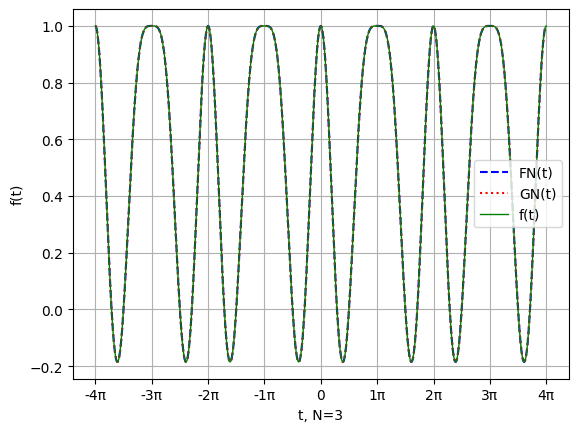

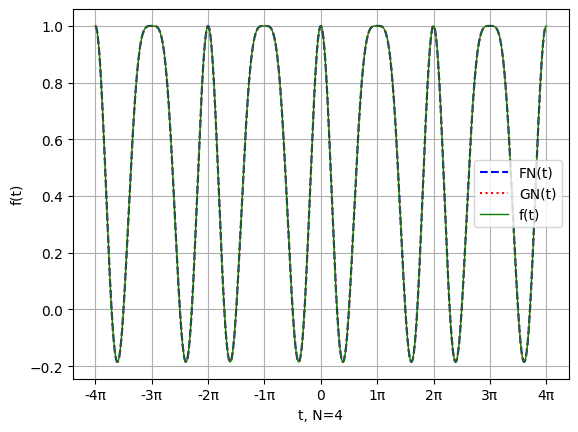

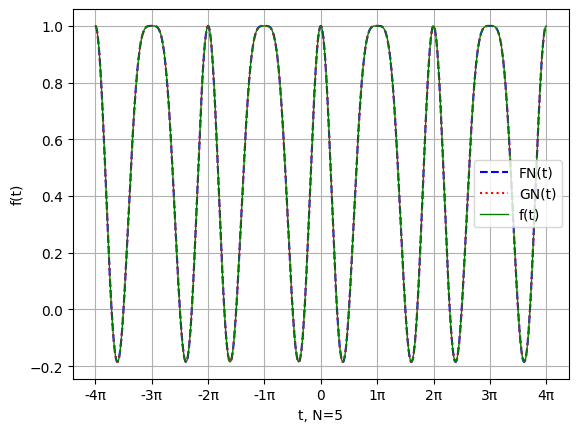

In [202]:
N = [1,2,3,4,5]

graphs2 = []

for n in N:
  yF = FN(x2, even_func, n, -np.pi, 2 * np.pi)
  yG = GN(x2, even_func, n, -np.pi, 2 * np.pi)

  graphs2.append(create_plot(x2, [yF, yG, y2], f"t, N={n}", "f(t)", ["FN(t)", "GN(t)", "f(t)"],
                colors=["blue", "red", "green"], linestyle=["--", ":", "-"], marker=["None", "None", "None"],
                linewidth=[1.5, 1.5, 1], markersize=[1, 1, 1], xPi=True))

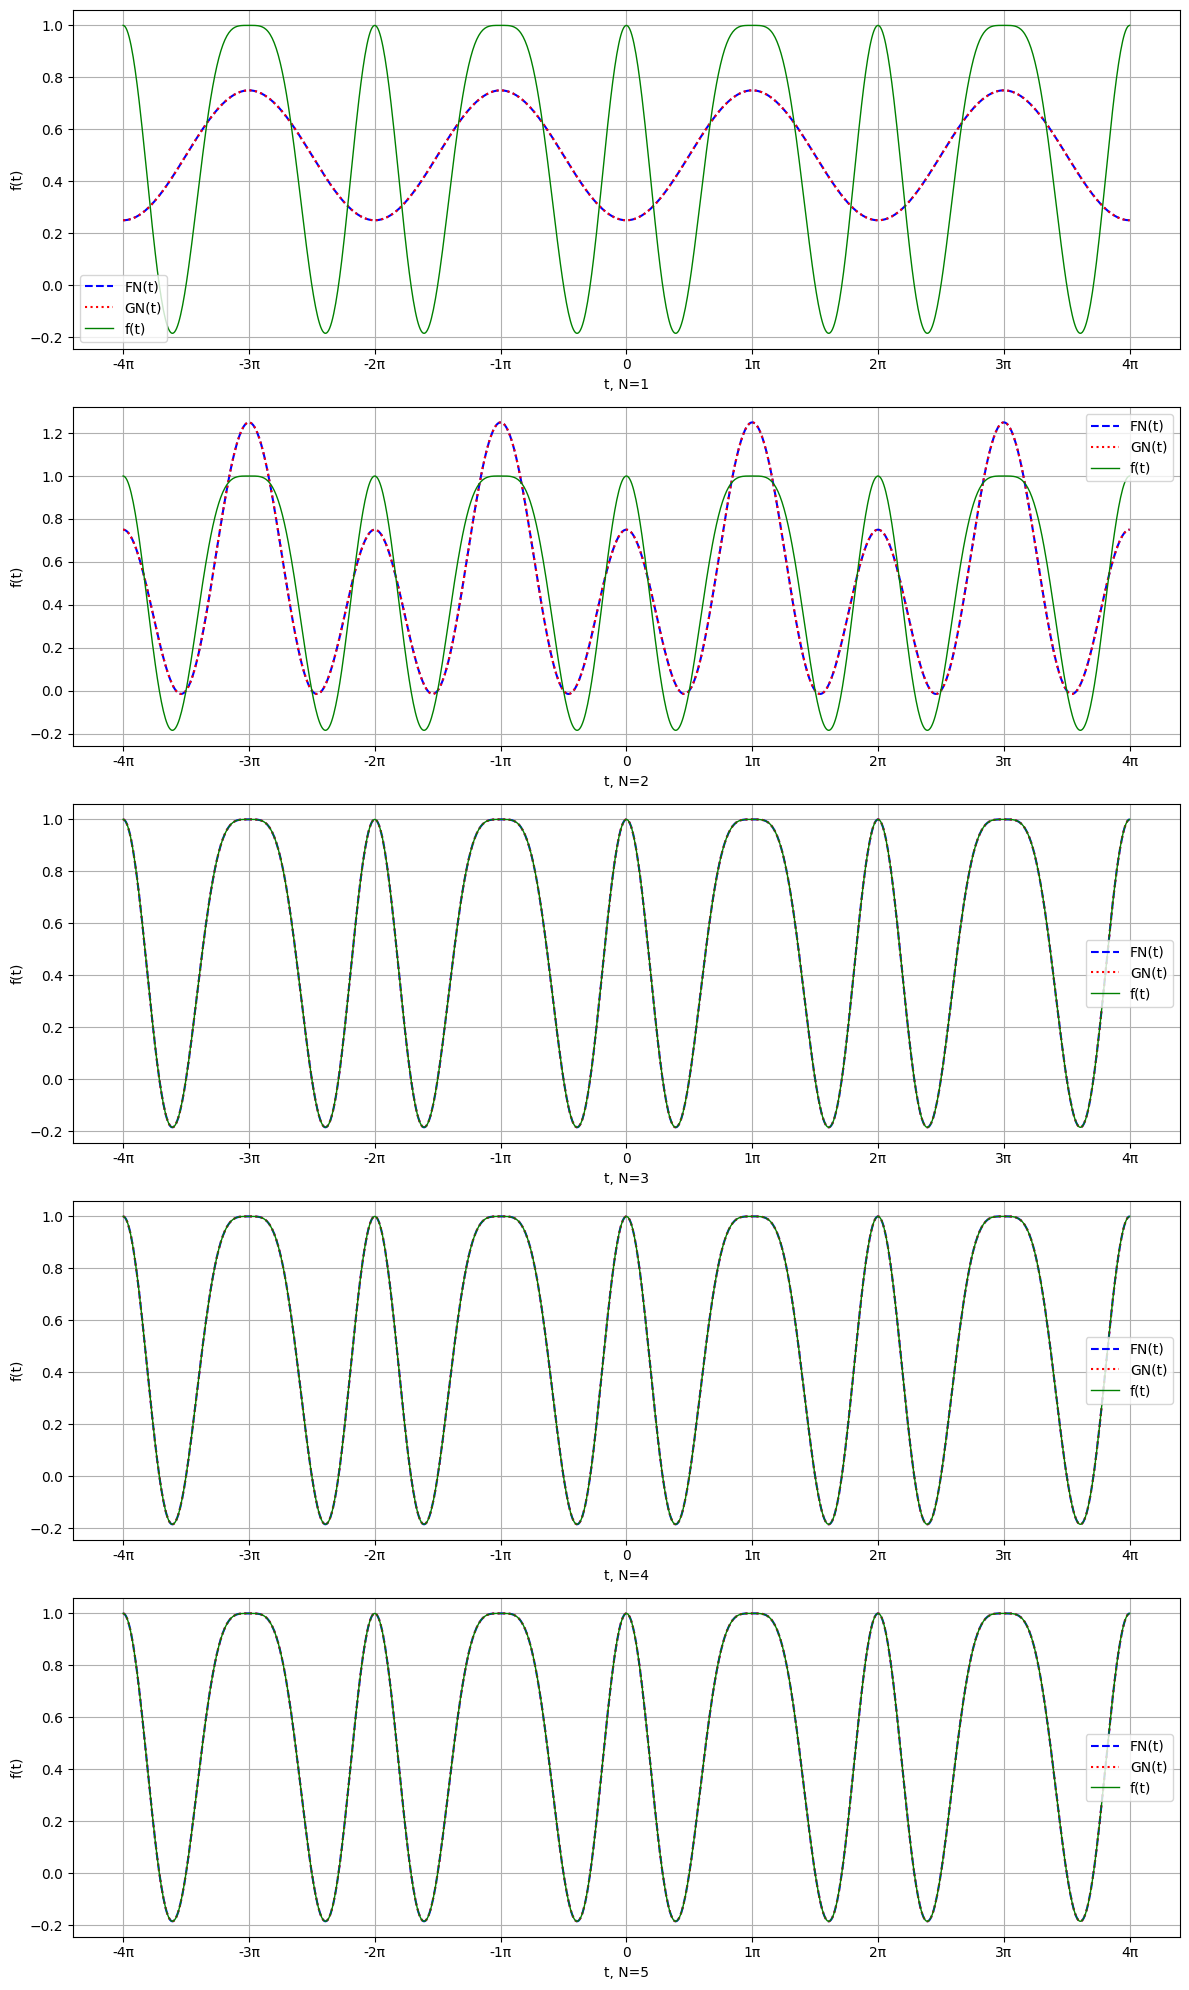

In [203]:
draw_subplots(graphs2, nrows=5, ncols=1, height=4, width=12)

### Проверка равенства Парсеваля
##### Для G_N(t)

In [204]:
cn_sum2 = sum_cn_coefs(get_quad_cn_hatch, even_func, -np.pi, 2 * np.pi, -22, 22)
even_func_norm = func_quad_norm(even_func, -np.pi, np.pi)

In [205]:
print("Сумма коэффицентов c_n': ", cn_sum2)
print("Квадрат нормы функции: ", even_func_norm)
print("Отклонение: ", round(abs(even_func_norm - cn_sum2) / even_func_norm * 100, 4), "%")

Сумма коэффицентов c_n':  2.7488935718898015
Квадрат нормы функции:  2.7488935718909615
Отклонение:  0.0 %


##### Для F_N(t)

In [206]:
an_bn_sum2 = sum_an_bn_coefs(get_an_bn, even_func, -np.pi, 2 * np.pi, 1, 22)

In [207]:
print("Сумма коэффицентов a_n', b_n': ", an_bn_sum2)
print("Отклонение: ", round(abs(even_func_norm - an_bn_sum2) / even_func_norm * 100, 4), "%")

Сумма коэффицентов a_n', b_n':  2.748893571889841
Отклонение:  0.0 %


# Нечётная функция

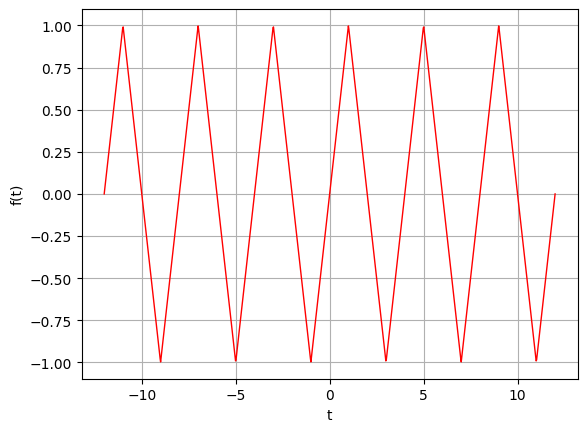

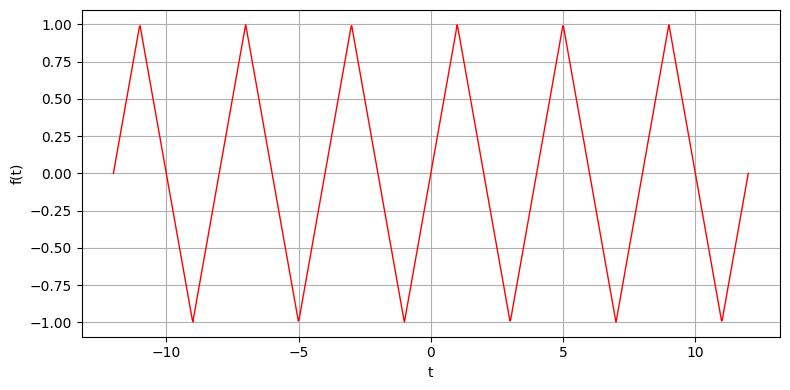

In [208]:
def odd_func(x: float) -> float:
    return abs((x - 1) % 4 - 2) - 1

x3 = np.linspace(-12, 12, 1000)
y3 = [odd_func(t) for t in x3]
odd_f_graph = create_plot(x3, [y3], "t", "f(t)", None, ["red"], False, linestyle=["-"])
draw_subplots([odd_f_graph], height=4, width=8)

## Вычисление коэффициентов нечётной функции

In [209]:
print_coefs(odd_func, 0, 4, 2, 3, 3, 12)

Коэффициенты рядов Фурье:
a_0:    0.0			c_0:              0j
a_1:   -0.0, b_1:  0.811	c_1:     (-0-0.405j), c_-1:     (-0+0.405j)
a_2:   -0.0, b_2:   -0.0	c_2:         (-0+0j), c_-2:         (-0-0j)


## Графики для различных N

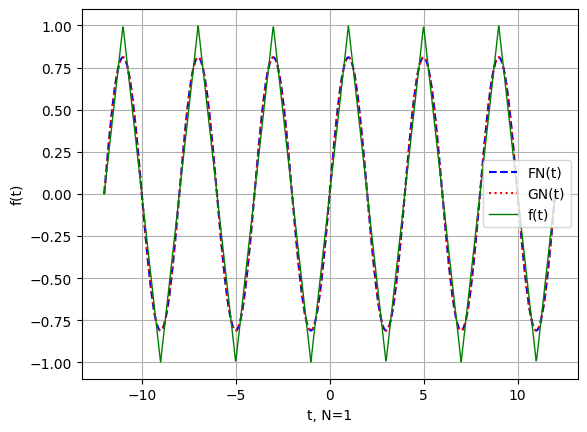

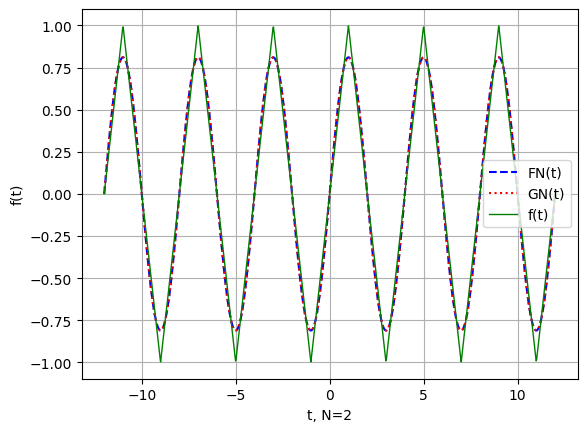

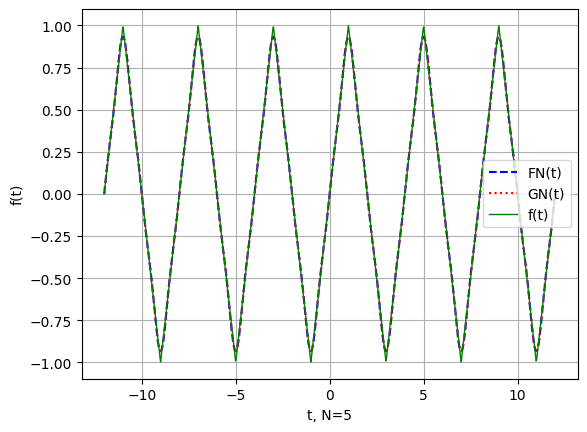

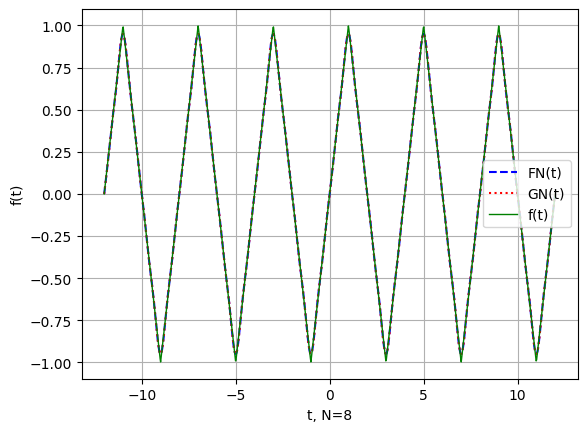

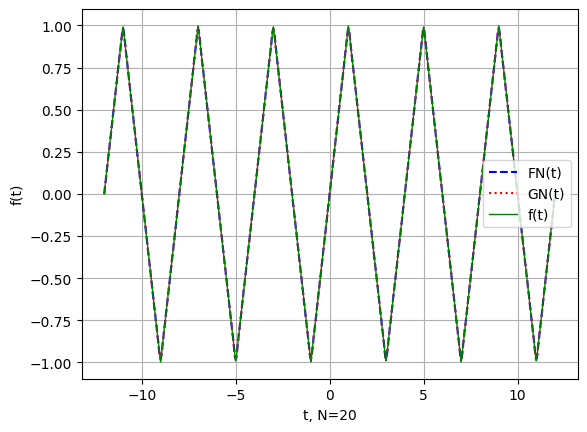

In [210]:
N = [1,2,5,8,20]
graphs3 = []

for n in N:
  yF = FN(x3, odd_func, n, 0, 4)
  yG = GN(x3, odd_func, n, 0, 4)

  graphs3.append(create_plot(x3, [yF, yG, y3], f"t, N={n}", "f(t)", ["FN(t)", "GN(t)", "f(t)"],
                colors=["blue", "red", "green"], linestyle=["--", ":", "-"], marker=["None", "None", "None"],
                linewidth=[1.5, 1.5, 1], markersize=[1, 1, 1], xPi=False))

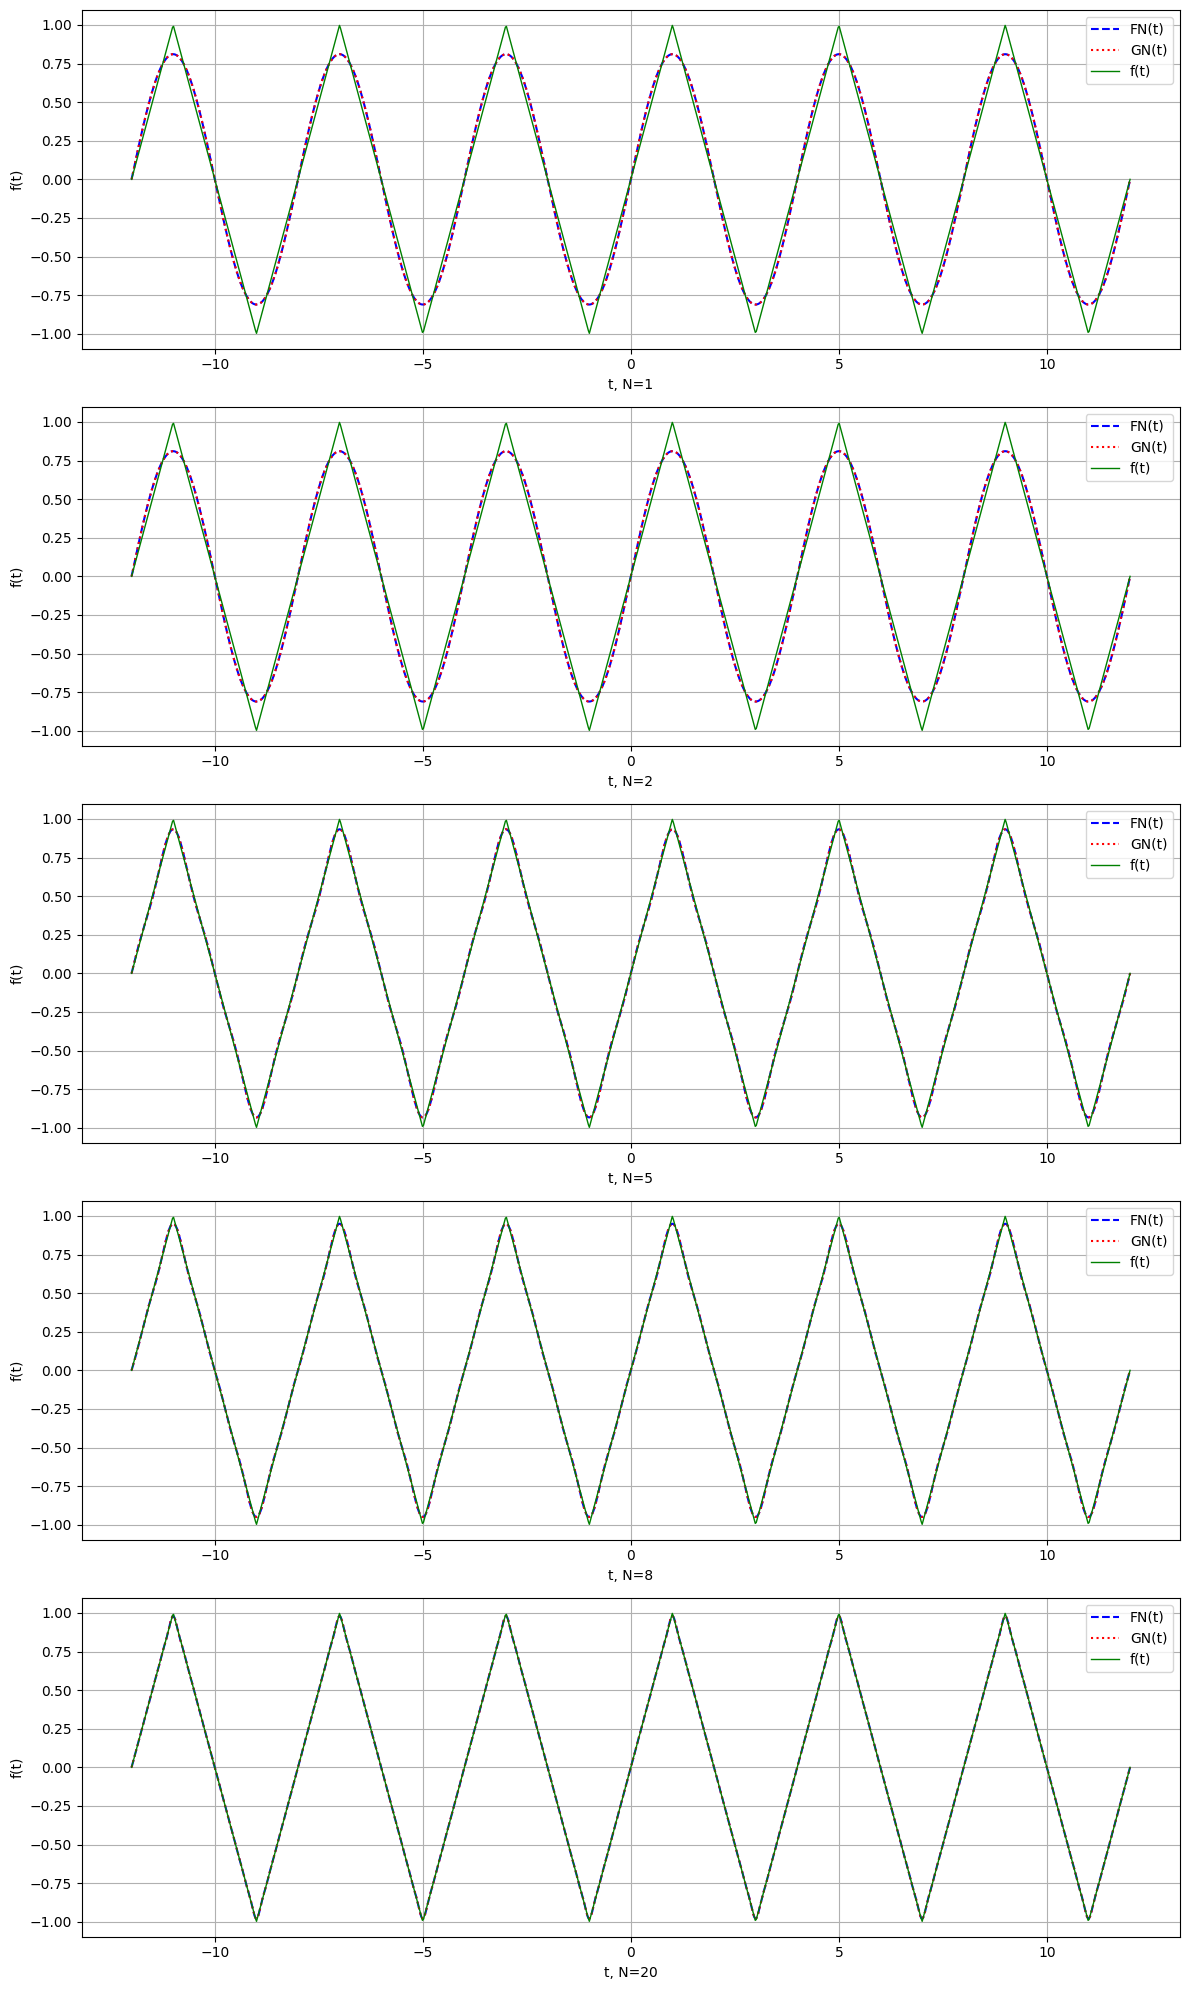

In [211]:
draw_subplots(graphs3, nrows=5, ncols=1, height=4, width=12)

### Проверка равенства Парсеваля
##### Для G_N(t)

In [212]:
cn_sum3 = sum_cn_coefs(get_quad_cn_hatch, odd_func, 0, 2 * np.pi, -70, 70)
odd_func_norm = func_quad_norm(odd_func, 0, 2 * np.pi)

In [213]:
print("Сумма коэффицентов c_n': ", cn_sum3)
print("Квадрат нормы функции: ", odd_func_norm)
print("Отклонение: ", round(abs(odd_func_norm - cn_sum3) / odd_func_norm * 100, 2), "%")

Сумма коэффицентов c_n':  2.007197602044068
Квадрат нормы функции:  2.007544608221687
Отклонение:  0.02 %


##### Для F_N(t)

In [214]:
an_bn_sum3 = sum_an_bn_coefs(get_an_bn, odd_func, 0, 2 * np.pi, 1, 70)

In [215]:
print("Сумма коэффицентов a_n', b_n': ", an_bn_sum3)
print("Отклонение: ", round(abs(odd_func_norm - an_bn_sum3) / odd_func_norm * 100, 2), "%")

Сумма коэффицентов a_n', b_n':  2.007197602044049
Отклонение:  0.02 %


# Случайная функция

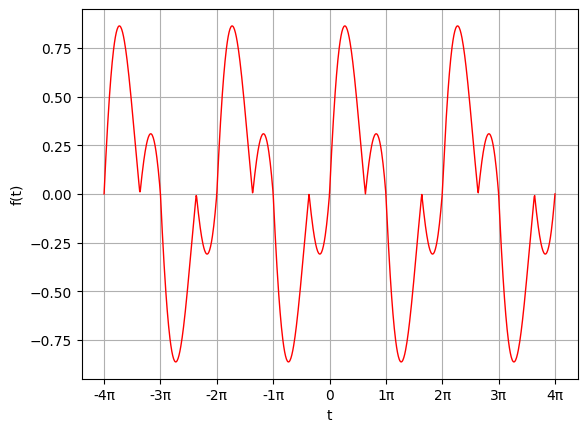

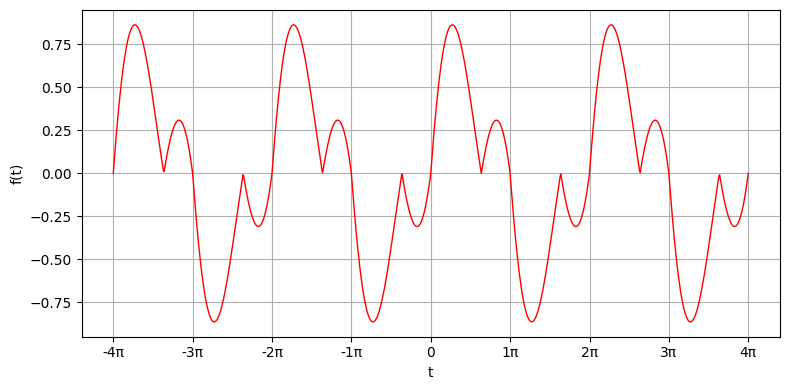

In [216]:
def random_func(x: float) -> float:
    return np.sin(x) * abs(x % np.pi - 2)

x4 = np.linspace(-4 * np.pi, 4 * np.pi, 1000)
y4 = [random_func(t) for t in x4]
random_f_graph = create_plot(x4, [y4], "t", "f(t)", None, ["red"], True, np.pi, linestyle=["-"], markersize=[1])
draw_subplots([random_f_graph], height=4, width=8)

## Вычисление коэффициентов случайной функции

In [217]:
print_coefs(random_func, 0, 2 * np.pi, 2, 3, 3, 12)

Коэффициенты рядов Фурье:
a_0:    0.0			c_0:              0j
a_1:  0.257, b_1:  0.581	c_1:   (0.129-0.29j), c_-1:   (0.129+0.29j)
a_2:   -0.0, b_2:    0.0	c_2:         (-0-0j), c_-2:         (-0+0j)


## Графики для различных N

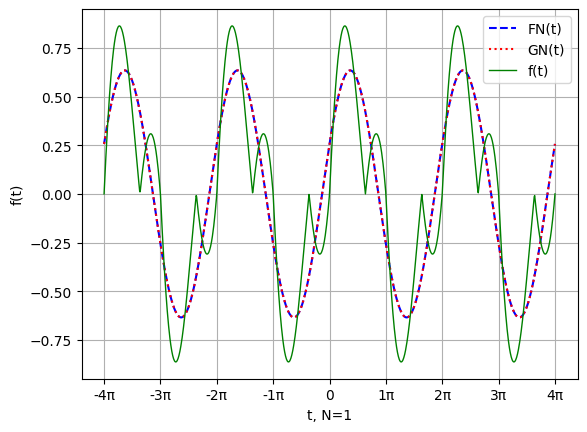

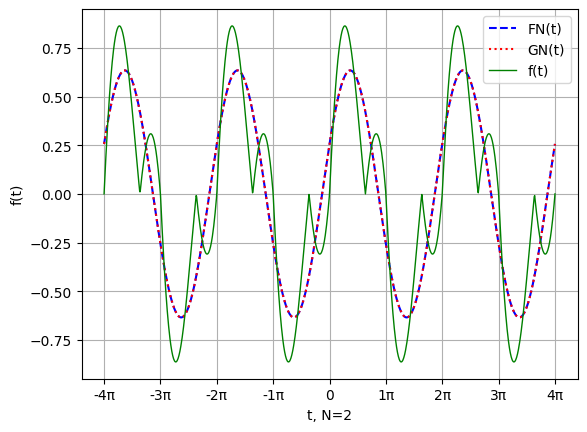

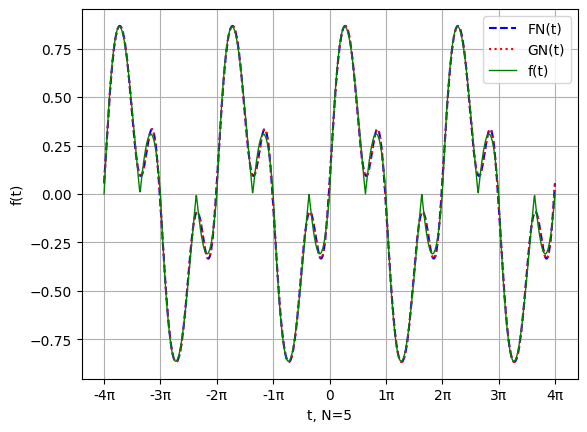

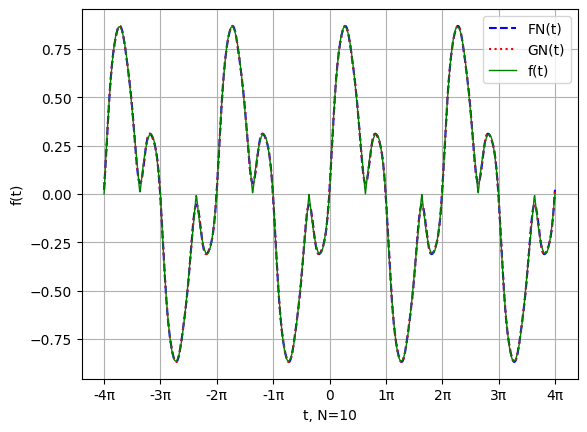

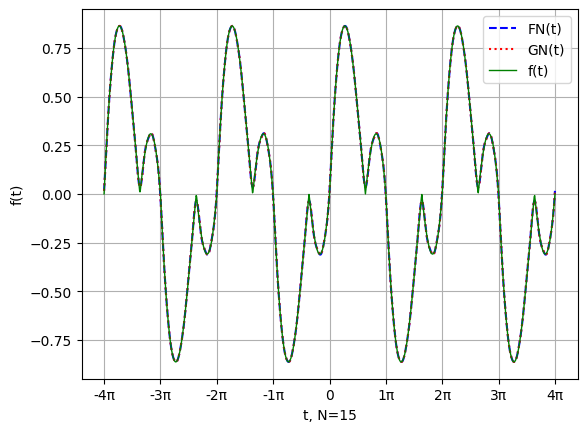

In [218]:
N = [1,2,5,10,15]

graphs4 = []
for n in N:
  yF = FN(x4, random_func, n, 0, 2 * np.pi)
  yG = GN(x4, random_func, n, 0, 2 * np.pi)

  graphs4.append(create_plot(x4, [yF, yG, y4], f"t, N={n}", "f(t)", ["FN(t)", "GN(t)", "f(t)"],
                colors=["blue", "red", "green"], linestyle=["--", ":", "-"], marker=["None", "None", "None"],
                linewidth=[1.5, 1.5, 1], markersize=[1, 1, 1], xPi=True))

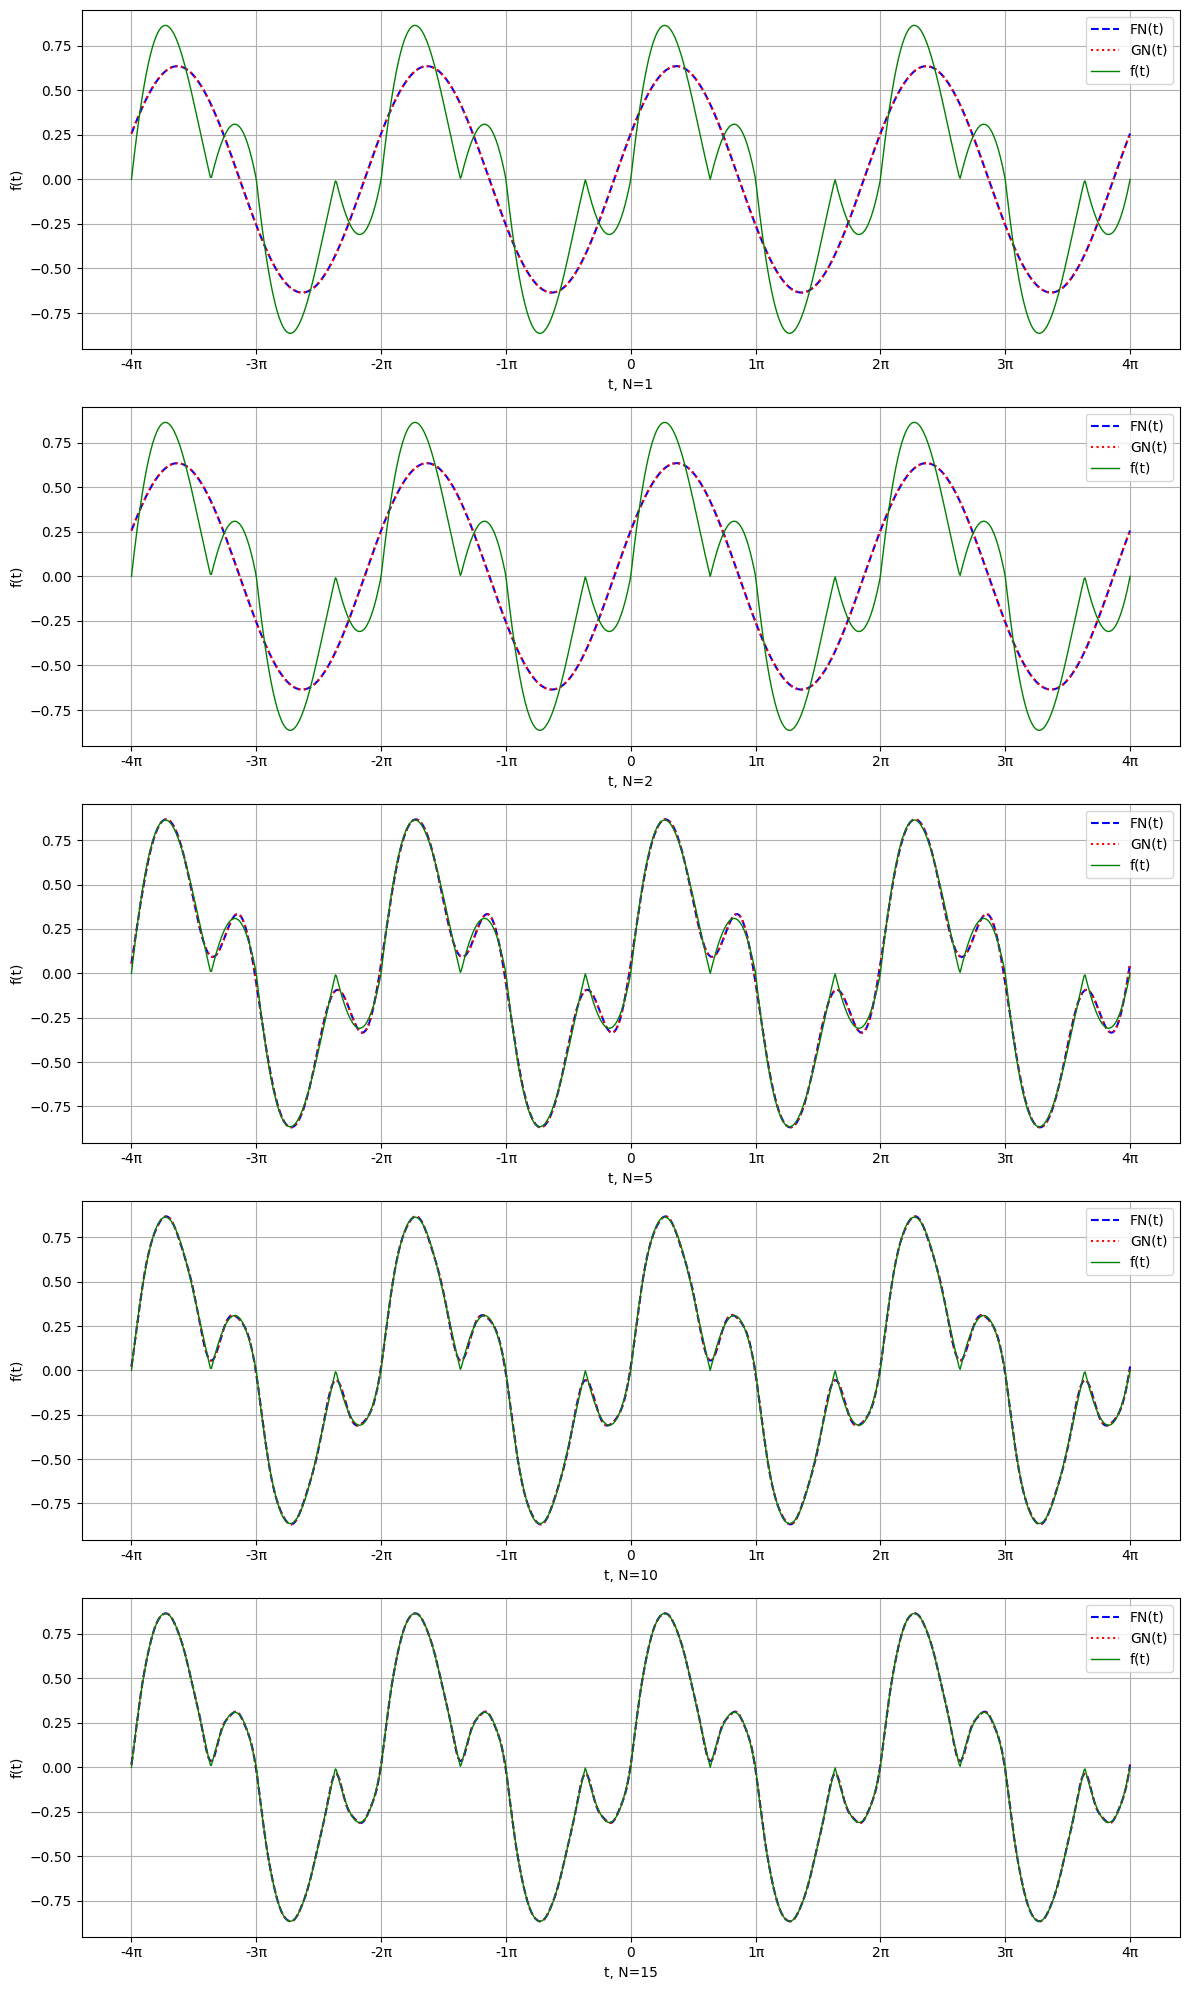

In [219]:
draw_subplots(graphs4, nrows=5, ncols=1, height=4, width=12)

### Проверка равенства Парсеваля
##### Для G_N(t)

In [220]:
cn_sum4 = sum_cn_coefs(get_quad_cn_hatch, random_func, 0, 2 * np.pi, -22, 22)
random_func_norm = func_quad_norm(random_func,  0, 2 * np.pi)

In [221]:
print("Сумма коэффицентов c_n': ", cn_sum4)
print("Квадрат нормы функции: ", random_func_norm)
print("Отклонение: ", round(abs(random_func_norm - cn_sum4) / random_func_norm * 100, 4), "%")

Сумма коэффицентов c_n':  1.5917122428156276
Квадрат нормы функции:  1.5917910454853152
Отклонение:  0.005 %


##### Для F_N(t)

In [222]:
an_bn_sum4 = sum_an_bn_coefs(get_an_bn, random_func,  0, 2 * np.pi, 1, 22)

In [223]:
print("Сумма коэффицентов a_n', b_n': ", an_bn_sum4)
print("Отклонение: ", round(abs(random_func_norm - an_bn_sum4) / random_func_norm * 100, 4), "%")

Сумма коэффицентов a_n', b_n':  1.5917122428156139
Отклонение:  0.005 %


# Комплексная функция

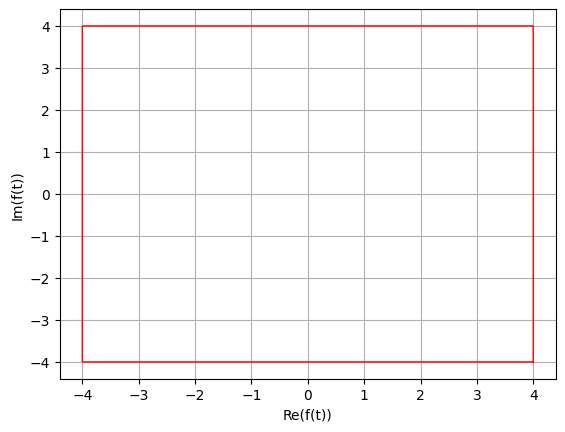

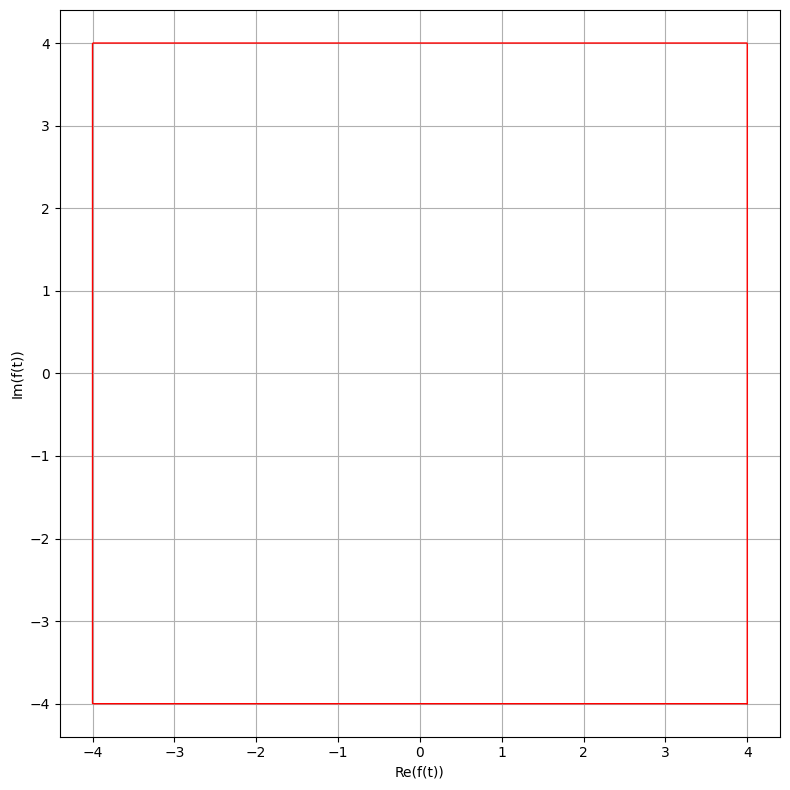

In [224]:
R = 4
T = 8

def Re_func(t):
    global R, T
    t_t = (t + T / 8) % T - T / 8
    if -T / 8 <= t_t < T / 8:
        return R
    elif T / 8 <= t_t < 3 * T / 8:
        return 2 * R - 8 * R * t_t / T
    elif 3 * T / 8 <= t_t < 5 * T / 8:
        return -R
    elif 5 * T / 8 <= t_t < 7 * T / 8:
        return -6 * R + 8 * R * t_t / T

def Im_func(t):
    global R, T
    t_t = (t + T / 8) % T - T / 8
    if -T / 8 <= t_t < T / 8:
        return 8 * R * t_t / T
    elif T / 8 <= t_t < 3 * T / 8:
        return R
    elif 3 * T / 8 <= t_t < 5 * T / 8:
        return 4 * R - 8 * R * t_t / T
    elif 5 * T / 8 <= t_t < 7 * T / 8:
        return -R
    
t_comp = np.linspace(-T / 8, T * 7 / 8, 2000)
Re_arr = [Re_func(t) for t in t_comp]
Im_arr = [Im_func(t) for t in t_comp]


comp_f_graph = create_plot(Re_arr, [Im_arr], "Re(f(t))", "Im(f(t))", None, ["red"], False, 10, linestyle=["-"], markersize=[1])
draw_subplots([comp_f_graph], height=8, width=8)

Вычисление коэффициентов комплексной функции

In [225]:
def comp_func(t):
    global R, T
    t_t = (t + T / 8) % T - T / 8
    if -T / 8 <= t_t < T / 8:
        return R + (8 * R * t_t / T) * 1j
    elif T / 8 <= t_t < 3 * T / 8:
        return 2 * R - 8 * R * t_t / T + R * 1j
    elif 3 * T / 8 <= t_t < 5 * T / 8:
        return -R + (4 * R - 8 * R * t_t / T) * 1j
    elif 5 * T / 8 <= t_t < 7 * T / 8:
        return -6 * R + 8 * R * t_t / T - R * 1j
    
def print_coefs_only_cn(f: Callable[[float], float], t0: float, T: float, N: int, precision: int, rp_ab: int, rp_c: int) -> None:
  c0 = get_cn_cn(f, t0, T, 0)[0]
  print("Коэффициенты рядов Фурье:")
  print(f"c_0: {np.round(c0, precision):>{precision + rp_c}}")
  for n in range(1, N + 1):
    cn, c_n = get_cn_cn(f, t0, T, n)
    print(f"c_{n}: {np.round(cn, precision):>{precision + rp_c}}, c_-{n}: {np.round(c_n, precision):>{precision + rp_c}}")

In [226]:
print_coefs_only_cn(comp_func, -T / 8, T / 7, 2, 3, 3, 12)

Коэффициенты рядов Фурье:
c_0:      (4-1.715j)
c_1: (-0.515+0.514j), c_-1:  (0.515+0.514j)
c_2:     (-0+0.364j), c_-2:          0.364j


Построим графики

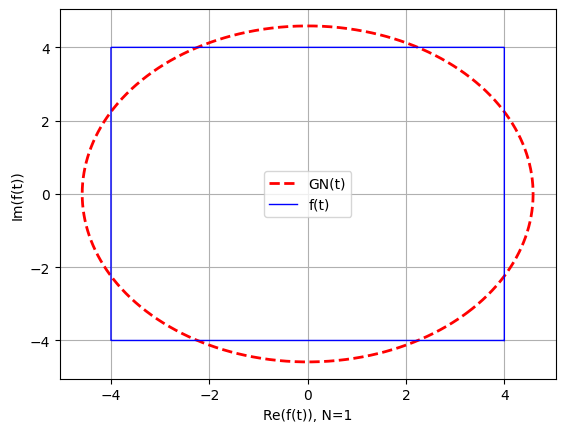

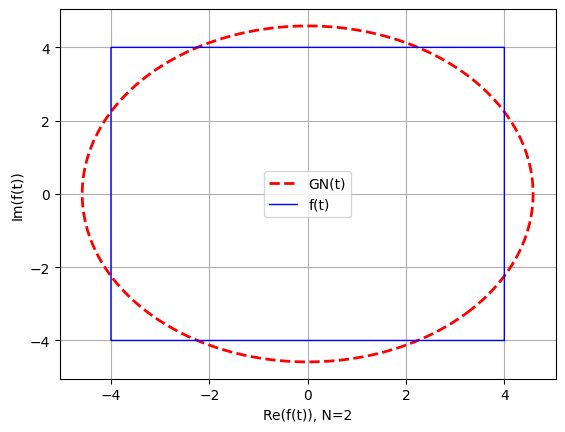

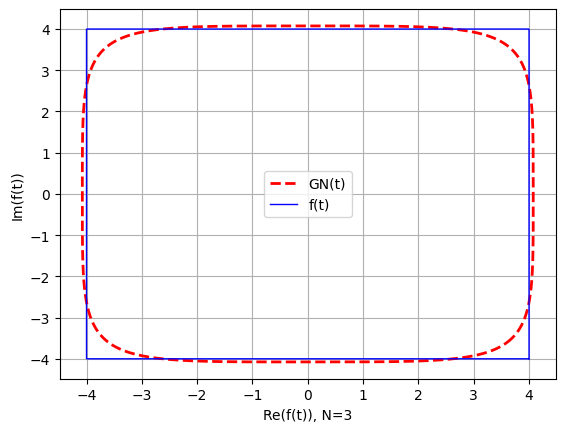

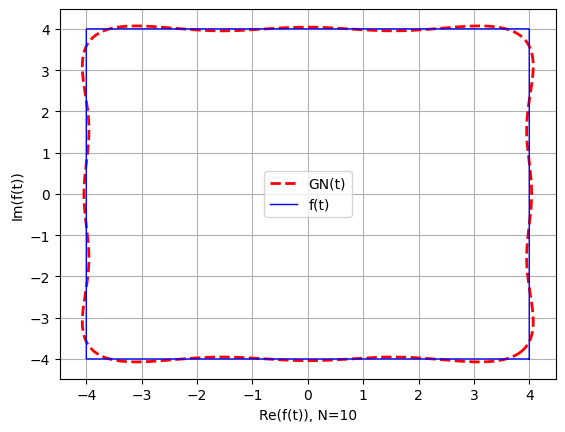

In [227]:
N = [1,2,3,10]

c_graphs = []

for n in N:
  yG_re = [t.real for t in GN(t_comp, comp_func, n, - T / 8, T)]
  yG_im = [t.imag for t in GN(t_comp, comp_func, n, - T / 8, T)]

  c_graphs.append(create_plot([yG_re, Re_arr], [yG_im, Im_arr], f"Re(f(t)), N={n}", "Im(f(t))", ["GN(t)", "f(t)"],
                colors=["red", "blue"], linestyle=["--", "-"], marker=["None", "None"],
                linewidth=[2, 1], markersize=[1, 1], xPi=False, markevery=[10, 1]))

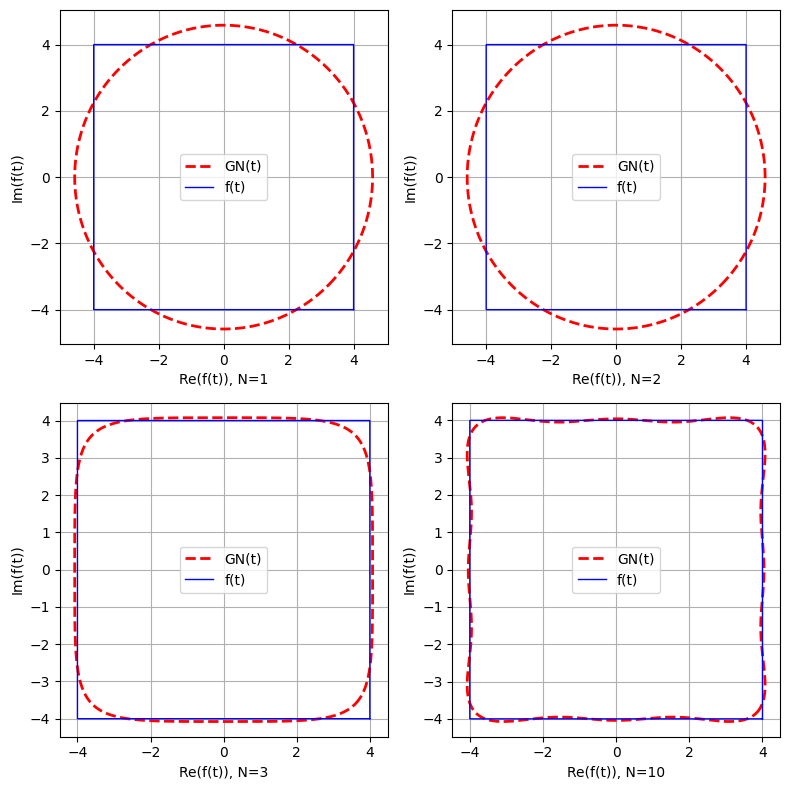

In [228]:
draw_subplots(c_graphs, nrows=2, ncols=2, height=4, width=4)

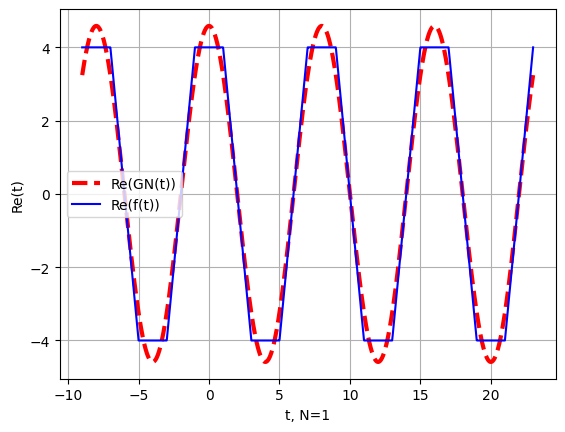

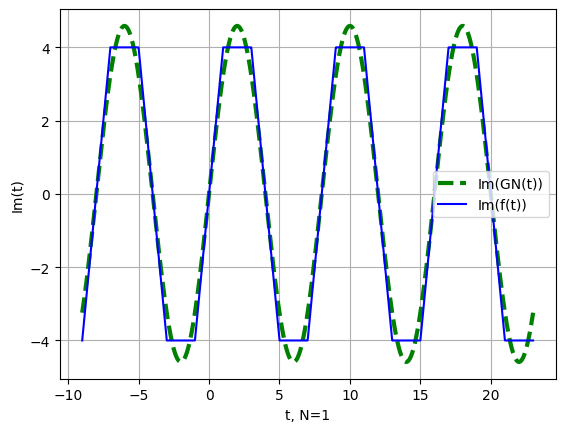

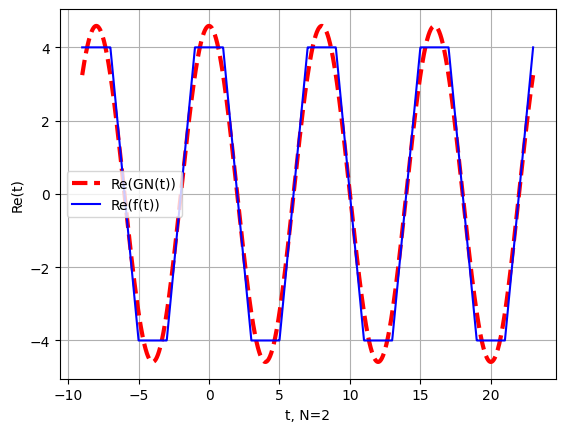

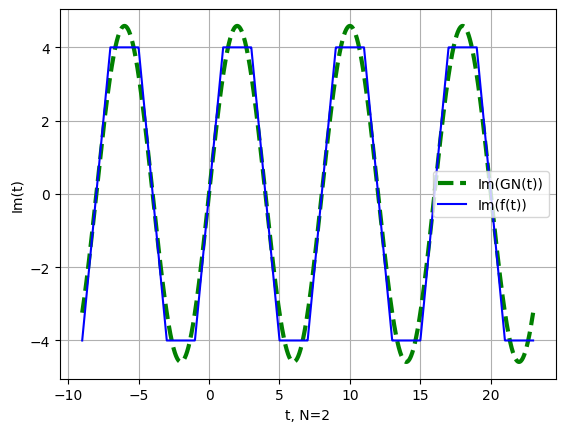

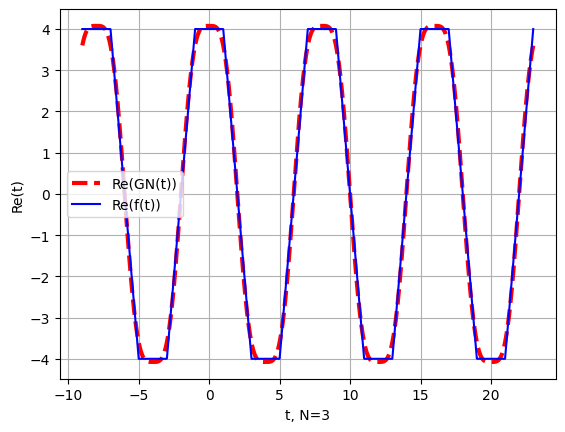

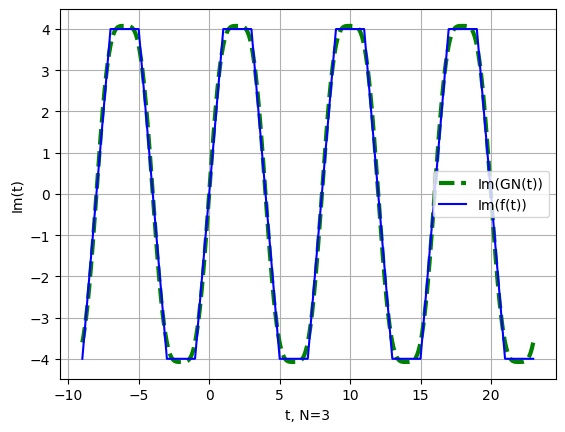

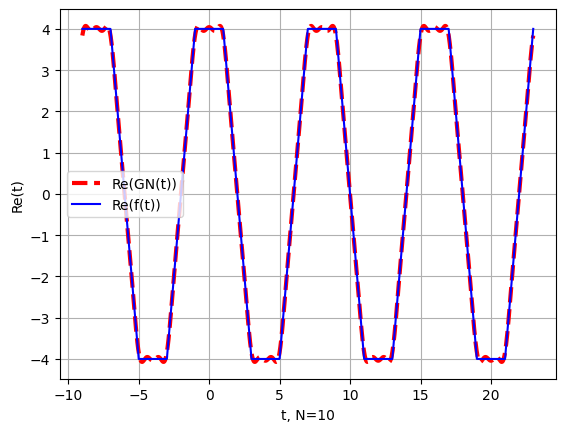

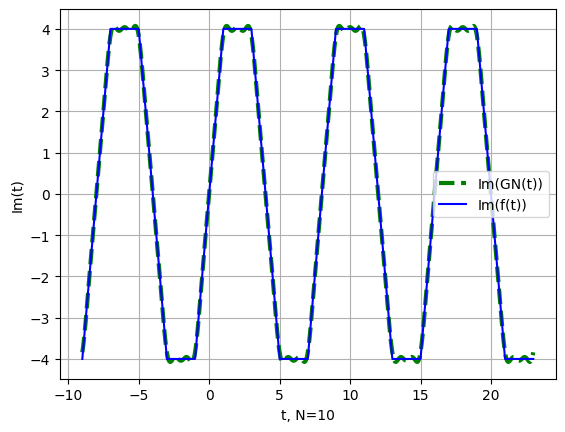

In [229]:
N = [1,2,3,10]

c_graphs_2 = []
t_comp2 = np.linspace(-T / 8 - T, T * 7 / 8 + 2 * T, 2000)
Re_arr2 = [Re_func(t) for t in t_comp2]
Im_arr2 = [Im_func(t) for t in t_comp2]

for n in N:
  yG_re = [t.real for t in GN(t_comp2, comp_func, n, - T / 8, T)]
  yG_im = [t.imag for t in GN(t_comp2, comp_func, n, - T / 8, T)]

  c_graphs_2.append(create_plot(t_comp2, [yG_re, Re_arr2], f"t, N={n}", "Re(t)", ["Re(GN(t))", "Re(f(t))"],
                colors=["red", "blue"], linestyle=["--", "-"], marker=["None", "None"],
                linewidth=[3, 1.5], markersize=[1, 1], xPi=False, markevery=[10, 1]))
  c_graphs_2.append(create_plot(t_comp2, [yG_im, Im_arr2], f"t, N={n}", "Im(t)", ["Im(GN(t))", "Im(f(t))"],
                colors=["green", "blue"], linestyle=["--", "-"], marker=["None", "None"],
                linewidth=[3, 1.5], markersize=[1, 1], xPi=False, markevery=[10, 1]))
  

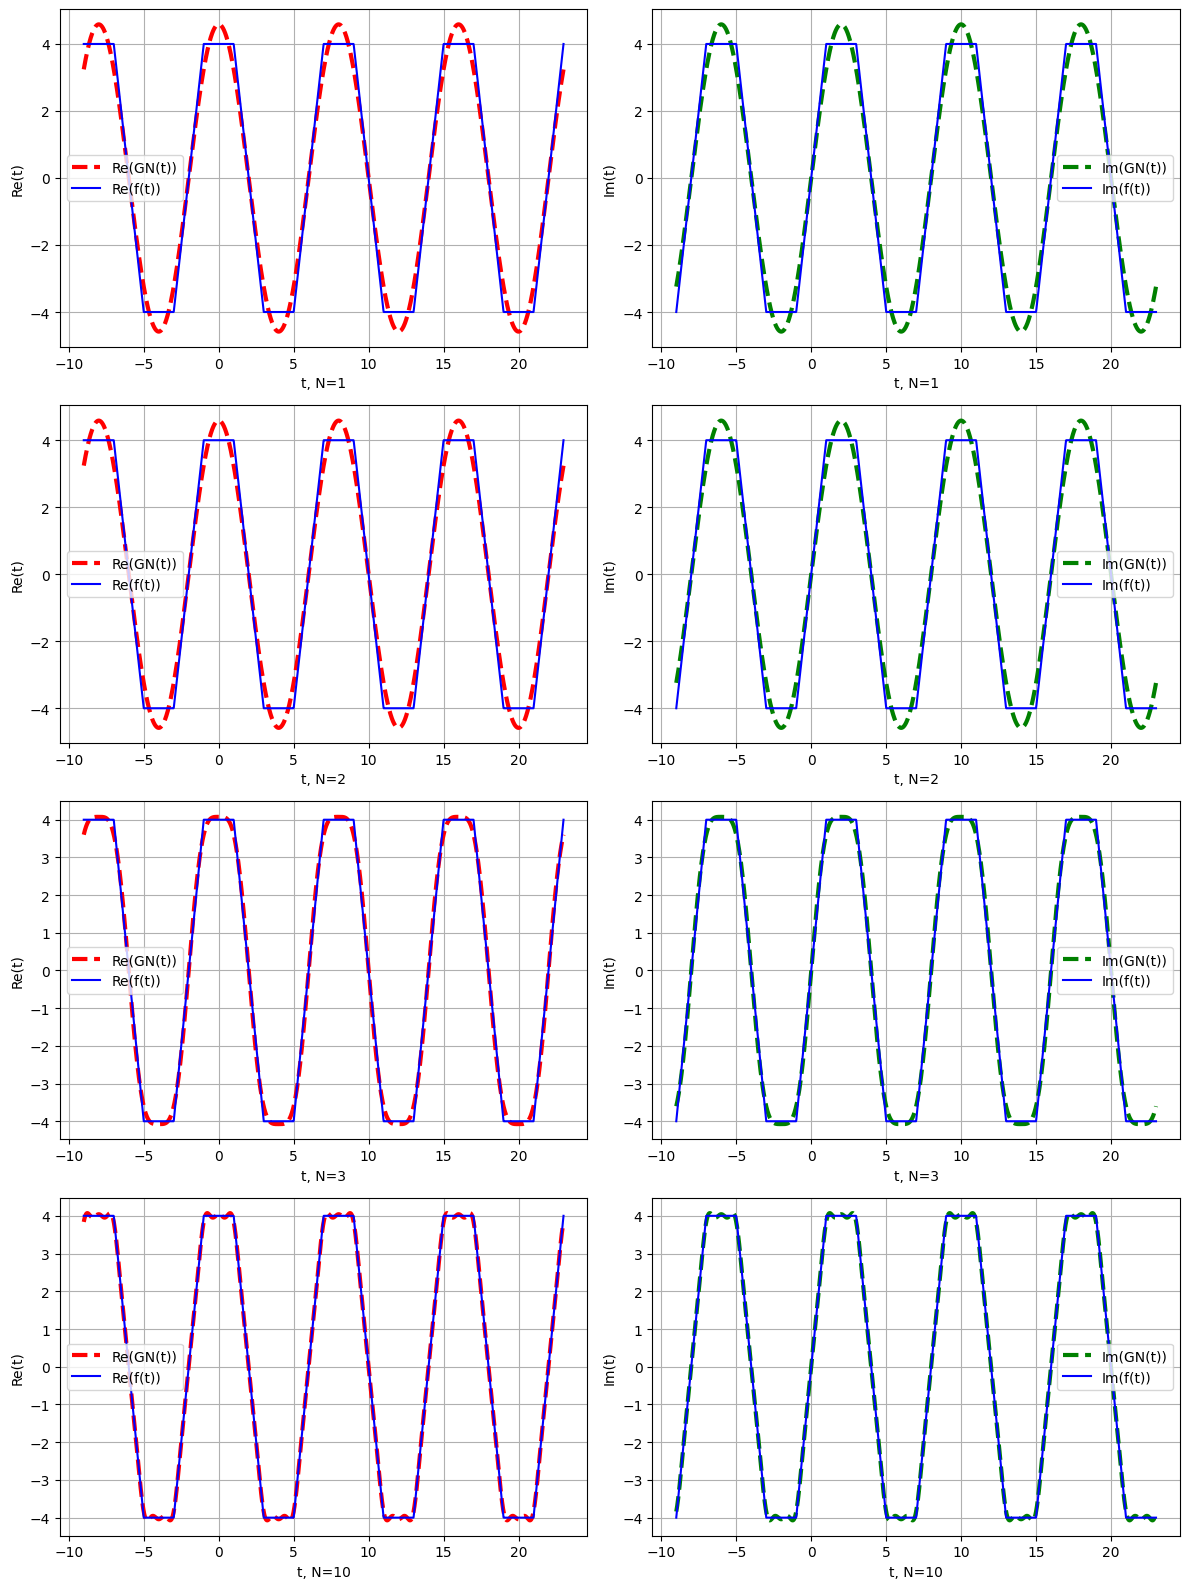

In [230]:
draw_subplots(c_graphs_2, nrows=4, ncols=2, height=4, width=6)

Проверка равенства Парсеваля

In [231]:
cn_sum_с = sum_cn_coefs(get_quad_cn_hatch, comp_func, -T / 8, T, -10, 10)
с_func_norm = func_quad_norm(comp_func, -T / 8, T * 7 / 8)
print("Сумма коэффицентов c_n': ", cn_sum_с)
print("Квадрат нормы функции: ", с_func_norm)
print("Отклонение: ", round(abs(с_func_norm - cn_sum_с) / с_func_norm * 100, 4), "%")

Сумма коэффицентов c_n':  170.63917599627726
Квадрат нормы функции:  170.66668031999416
Отклонение:  0.0161 %


# Рисуем кота

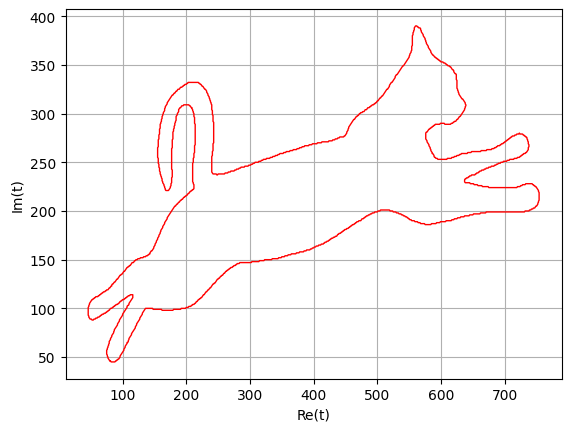

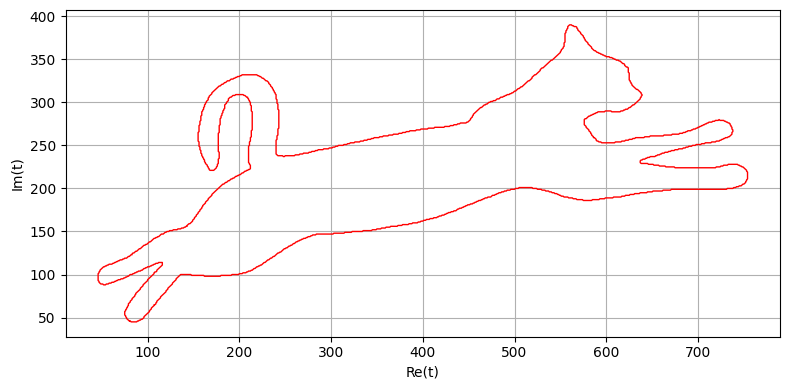

In [232]:
cat_img = cv2.flip(cv2.imread('cat.png', cv2.IMREAD_GRAYSCALE), 0)

my_photo = cv2.flip(cv2.imread('cat.png', cv2.IMREAD_GRAYSCALE), 0)
ret,thresh_img = cv2.threshold(my_photo, 1, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours = np.uint8(np.zeros((my_photo.shape[0],my_photo.shape[1])))
cat_coordinates = contours[1].squeeze().T

cat_graph = create_plot(cat_coordinates[0], [cat_coordinates[1]], "Re(t)", "Im(t)", None, ["red"], False, marker=["None"], linestyle=["-"], linewidth=[1])
draw_subplots([cat_graph], height=4, width=8)

In [233]:
cat_coordinates
T_cat = cat_coordinates.shape[1]

def cat_func(x):
    global cat_coordinates, T_cat
    return float(cat_coordinates[0, int(x) % T_cat]) + float(cat_coordinates[1, int(x) % T_cat]) * 1j

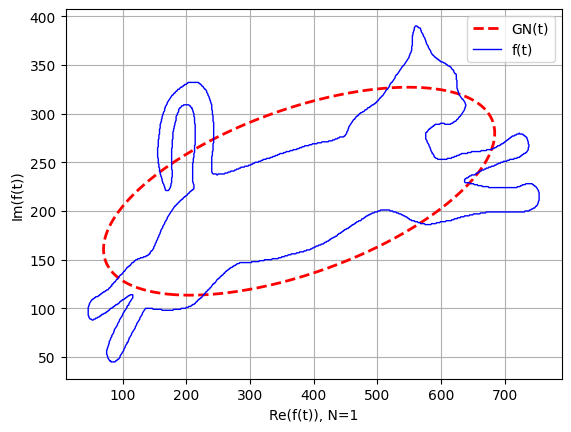

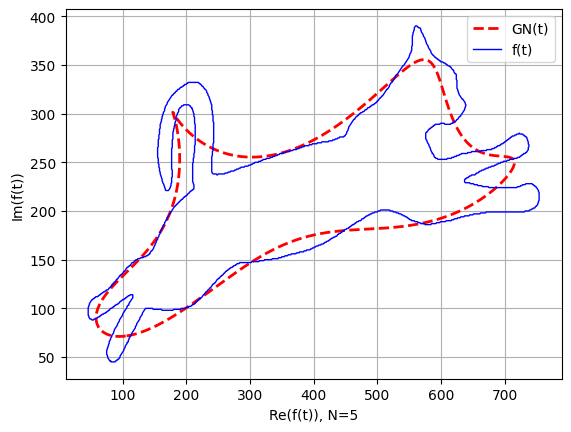

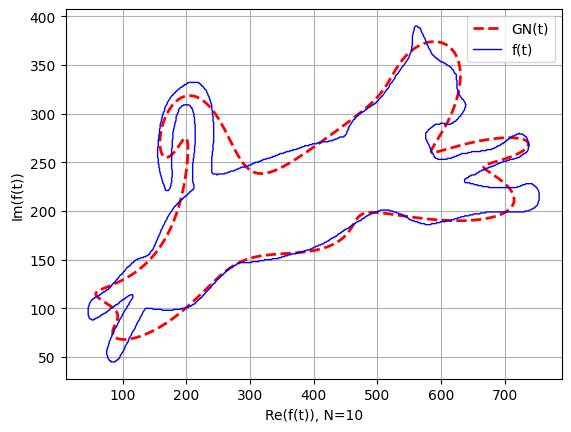

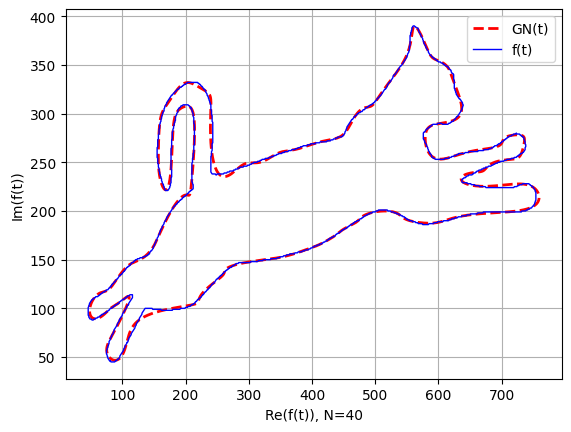

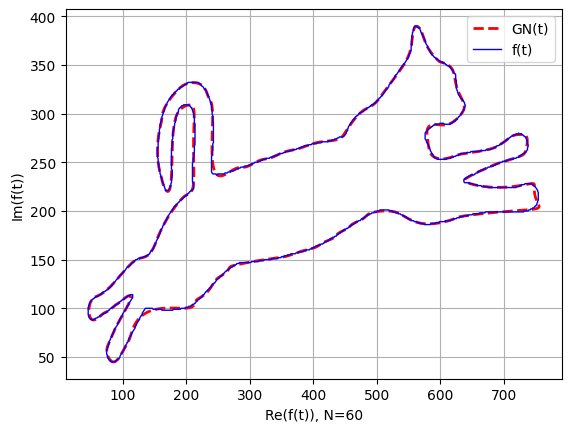

In [234]:
STEPS_PER_T = 100
N = [1, 5, 10, 40, 60]

t_cat = np.linspace(0, T_cat, 2000)
cat_graphs = []

Re_arr_cat = [cat_func(t).real for t in t_cat]
Im_arr_cat = [cat_func(t).imag for t in t_cat]
for n in N:
  yG_re = [t.real for t in GN(t_cat, cat_func, n, 0, T_cat)]
  yG_im = [t.imag for t in GN(t_cat, cat_func, n, 0, T_cat)]

  cat_graphs.append(create_plot([yG_re, Re_arr_cat], [yG_im, Im_arr_cat], f"Re(f(t)), N={n}", "Im(f(t))", ["GN(t)", "f(t)"],
                colors=["red", "blue"], linestyle=["--", "-"], marker=["None", "None"],
                linewidth=[2, 1], markersize=[1, 1], xPi=False, markevery=[10, 1]))
  

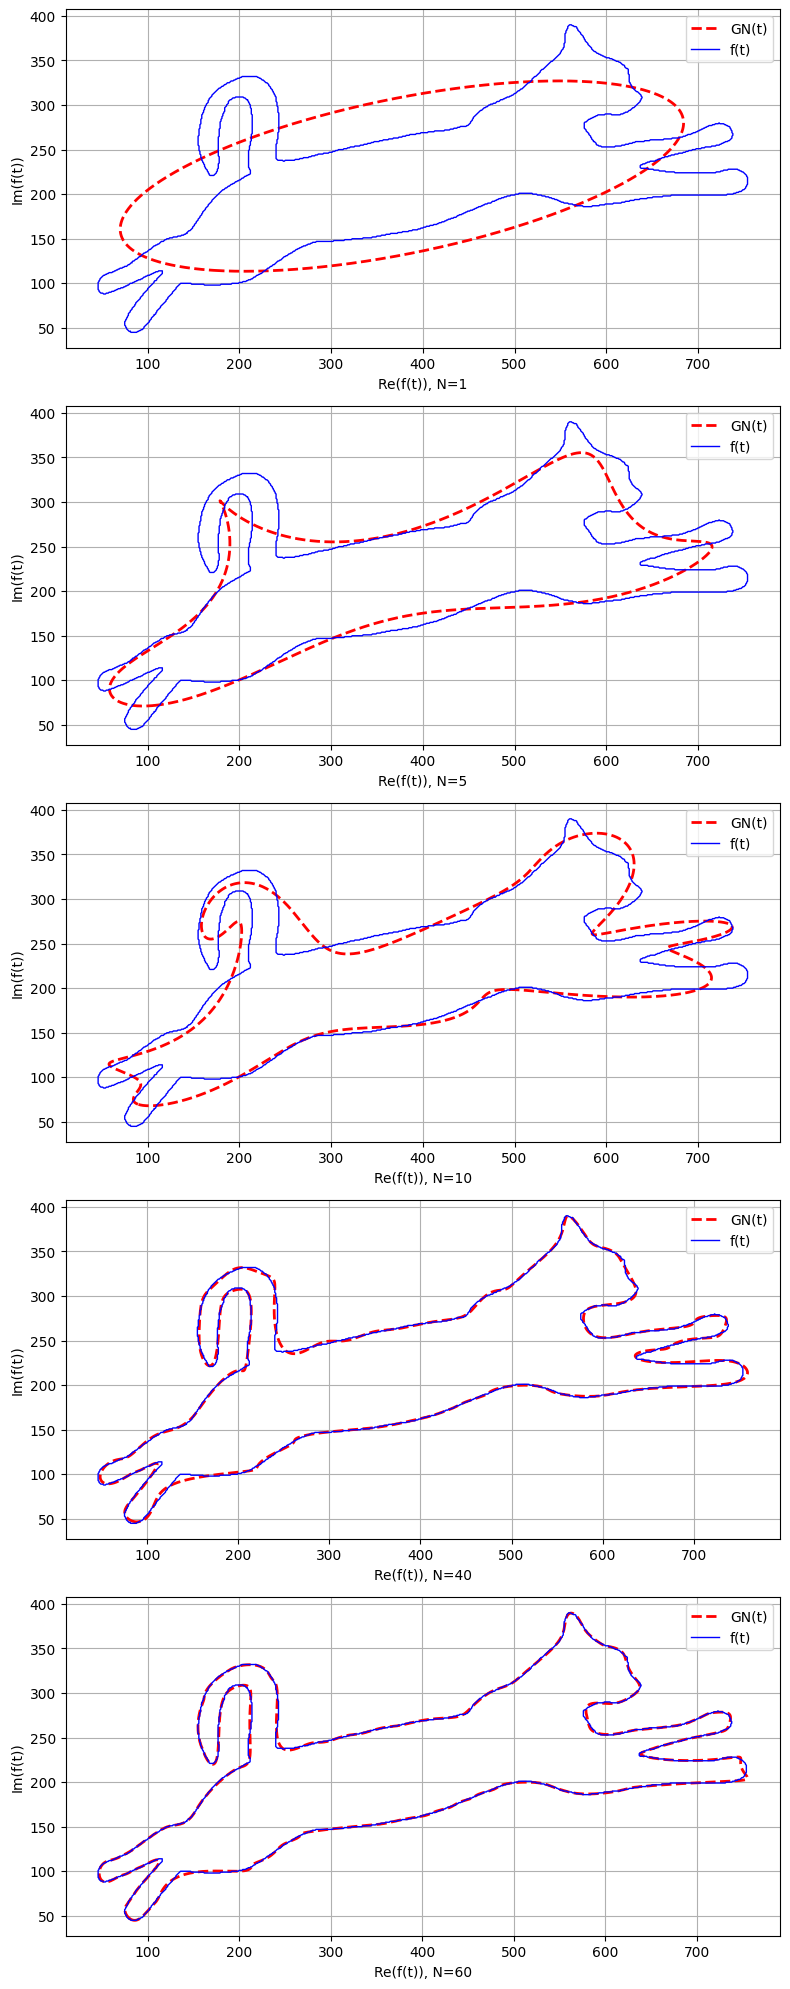

In [235]:
draw_subplots(cat_graphs, nrows=5, ncols=1, height=4, width=8)